In [6]:
import os 
import glob 
import xarray as xr 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import shutil
from scipy.stats import linregress
import cartopy.io.shapereader as shpreader
from shapely.geometry import shape
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import unary_union
from shapely.prepared import prep
import regionmask
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import seaborn as sns
import scipy.stats as stats
import geopandas as gpd
import xesmf as xe
from matplotlib.ticker import ScalarFormatter
from shapely.geometry import Point
import matplotlib.cm as cm
import calendar
from collections import Counter
import itertools
import rasterio
import struct
from datetime import datetime, timedelta
from tqdm import tqdm
import subprocess
import urllib.request
import zipfile

# Set global font to a sans-serif type suitable for publishing
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans'],  # Use 'Helvetica' or 'DejaVu Sans' if Arial is unavailable
    'font.size': 8,               # Default font size
    'axes.titlesize': 8,          # Title font size
    'axes.labelsize': 8,          # X and Y labels font size
    'xtick.labelsize': 8,         # X-axis tick labels font size
    'ytick.labelsize': 8,         # Y-axis tick labels font size
    'legend.fontsize': 8,         # Legend font size
    'figure.titlesize': 8         # Figure title font size
})

ModuleNotFoundError: No module named 'cartopy'

# Change inputs

Files structure is .$home/PRISM/{var_name}/netdf

In [5]:
# home = '/home/ib28/mymount/sd75/isabelleb/wastewater/PRISM'
home = '/home/sd96/rdf'
# home = '/home/sd96/wastewater'
# shapefile = os.path.join(home, 'harris_county.geojson')
shapefile = os.path.join(home, 'tl_2024_us_state', 'tl_2024_us_state.shp')
# shapefile = "/home/ib28/mymount/sd75/isabelleb/wastewater/shapefiles/Regional_County_Boundaries.shp"

# Downloading BIL Files from PRISM 

    Saves zip files in rdf in folders `zip_ppt`, `zip_tmean`, `zip_tdmean`
    Saves unziped files in rdf folders `ppt`, `tmean`, `tdmean`

In [4]:
daily = "D2"
monthly = "M3"
clim_var = "ppt"
folder = os.path.join(home, f'zip_{clim_var}')
base_url = "https://services.nacse.org/prism/data/public/4km"
start = datetime.strptime("2020-01-01", "%Y-%m-%d")
stop = datetime.strptime("2024-12-31", "%Y-%m-%d")

NameError: name 'home' is not defined

In [ ]:
# def _progress_hook(block_num, block_size, total_size, t):
#     """
#     Callback function to update tqdm progress bar during file download.
#     """
#     downloaded = block_num * block_size
#     if total_size > 0:
#         t.update(min(block_size, total_size - t.n))
#     else:
#         t.update(downloaded - t.n)

# while start <= stop:
#     day = start.strftime("%Y%m%d")
#     url = f"{base_url}/{clim_var}/{day}"
#     output_file = os.path.join(folder, day)

#     with tqdm(unit='B', unit_scale=True, unit_divisor=1024, miniters=1, desc=f'Downloading {day}') as t:
#         urllib.request.urlretrieve(url, output_file, reporthook=lambda block_num, block_size, total_size: _progress_hook(block_num, block_size, total_size, t))

#     start += timedelta(days=1)

In [ ]:
def parse_header(hdr_path):
    """Parses a .hdr file and returns a dictionary of header information."""
    header = {}
    with open(hdr_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                header[parts[0].upper()] = parts[1]
    return header

def read_bil_manual(bil_path, hdr_path):
    """
    Reads a .bil file manually using information from its .hdr file.
    """
    header = parse_header(hdr_path)

    nrows = int(header.get('NROWS', 0))
    ncols = int(header.get('NCOLS', 0))
    nbits = int(header.get('NBITS', 0))
    byteorder = header.get('BYTEORDER', 'I') # 'I' for Intel (little-endian), 'M' for Motorola (big-endian)
    pixeltype = header.get('PIXELTYPE', 'SIGNEDINT') # Example: FLOAT, SIGNEDINT, UNSIGNEDINT

    # Determine data type for struct and numpy
    if nbits == 8:
        dtype = np.int8 if pixeltype == 'SIGNEDINT' else np.uint8
        fmt_char = 'b' if pixeltype == 'SIGNEDINT' else 'B'
    elif nbits == 16:
        dtype = np.int16 if pixeltype == 'SIGNEDINT' else np.uint16
        fmt_char = 'h' if pixeltype == 'SIGNEDINT' else 'H'
    elif nbits == 32:
        if pixeltype == 'FLOAT':
            dtype = np.float32
            fmt_char = 'f'
        else:
            dtype = np.int32 if pixeltype == 'SIGNEDINT' else np.uint32
            fmt_char = 'i' if pixeltype == 'SIGNEDINT' else 'I'
    else:
        raise ValueError(f"Unsupported NBITS: {nbits}")

    endian_prefix = '<' if byteorder == 'I' else '>' # Little-endian or Big-endian

    with open(bil_path, 'rb') as f:
        bil_data = f.read()

    # Unpack binary data
    num_elements = nrows * ncols
    format_string = f"{endian_prefix}{num_elements}{fmt_char}"
    unpacked_data = struct.unpack(format_string, bil_data)

    # Reshape into a 2D array
    data_array = np.array(unpacked_data, dtype=dtype).reshape(nrows, ncols)

    return data_array

# Example usage:
bil_file = os.path.join(home, f'{clim_var}', f'PRISM_{clim_var}_stable_4km{daily}_20210101_bil.bil') 
hdr_file = os.path.join(home, f'{clim_var}', f'PRISM_{clim_var}_stable_4km{daily}_20210101_bil.hdr') 
bil_data_manual = read_bil_manual(bil_file, hdr_file)

In [ ]:
# Read raster data from .bil file
bil_file_path = os.path.join(home, f'{clim_var}', f'PRISM_{clim_var}_stable_4km{daily}_20210101_bil.bil') 

# Use rasterio to read the raster data
with rasterio.open(bil_file_path) as src:
    raster_data = src.read(1)
    transform = src.transform

# Visualize data on the map
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the desired minimum and maximum values for the colormap
vmin = 0  
vmax = 100  

# Plot the raster data using imshow with vmin and vmax
im = ax.imshow(raster_data, extent=(transform[2], transform[2] + transform[0] * raster_data.shape[1],
                                    transform[5] + transform[4] * raster_data.shape[0], transform[5]),
               origin='upper', cmap='viridis', alpha=0.5, vmin=vmin, vmax=vmax)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.1, shrink=0.4)
cbar.set_label('Raster Value')

# Add gridlines and coastlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.coastlines()

# Set aspect ratio to 'equal'
ax.set_aspect('equal')

plt.show()

In [ ]:
# Convert the data into an xarray dataset 

def create_array_with_step(N, start_value, step): 
    result_array = []
    for i in range(N): 
        result_array.append(start_value + i * step) 
    return np.array(result_array)

header_data = parse_header(hdr_file)
x0 = float(header_data['ULXMAP'])
y0 = float(header_data['ULYMAP'])
dx = float(header_data['XDIM'])
dy = float(header_data['YDIM'])
    
Nx = raster_data.shape[1]
Ny = raster_data.shape[0]
# dx = transform[0]
# dy = transform[4]
# x0 = transform[2]
# y0 = transform[5] 
    
longitude = create_array_with_step(Nx, x0, dx)
latitude = create_array_with_step(Ny, y0, -dy) 
filename_parts = bil_file_path.split('.')[0].split('_') 

# Daily 
timestamp = np.array([datetime.strptime(filename_parts[4], '%Y%m%d')]) 

# Monthly 
# timestamp = np.array([datetime.strptime(filename_parts[4], '%Y%m')]) 
var_data = np.expand_dims(raster_data, axis=2)

In [ ]:
ds = xr.Dataset(
    data_vars=dict(
        tmean=(('lat', 'lon', 'time'), var_data),
    ),
    coords=dict(
        lon=('lon', longitude),
        lat=('lat', latitude),
        time=('time', timestamp), 
    ),
    attrs=dict(description="PRISM data"),
)

In [ ]:

plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
levels = np.arange(-10, 31, 1) 
ds = ds.sortby('lat') 
ds_plot = ds.sel(lat = slice(25, 37), lon = slice(-107, -93)) 
ds_plot = ds_plot.where(ds_plot.tmean > -8000, drop = True) 
levels = np.arange(-18, 19, 1)
ds_plot.sel(time = '20210101').tmean.plot(x = 'lon', y = 'lat', ax = ax, levels = levels)

# shapefile = '/home/ib28/mymount/sd75/isabelleb/BWF_Pres/tl_2024_us_state.shp'
shapefile = os.path.join(home, 'tl_2024_us_state', 'tl_2024_us_state.shp')
states = gpd.read_file(shapefile)

##### Filter for Texas #####
texas = states[states['NAME'] == 'Texas']

##### Plot Texas Boundary #####
texas.boundary.plot(ax=ax, color='black', alpha = 0.5, linewidth=1)

# Read all datasets into NetCDF format

In [ ]:
def parse_header(hdr_file_path):
    """Parses a .hdr file and returns a dictionary of header information."""
    header = {}
    with open(hdr_file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                header[parts[0].upper()] = parts[1]
    return header

def parse_bil(bil_file_path): 
    # Use rasterio to read the raster data
    with rasterio.open(bil_file_path) as src:
        raster_data = src.read(1)
    return raster_data       

def create_array_with_step(N, start_value, step): 
    result_array = []
    for i in range(N): 
        result_array.append(start_value + i * step) 
    return np.array(result_array)

In [ ]:
variables = ['tmean', 'tdmean', 'ppt'] 
years = ['2020', '2021', '2022', '2023', '2024']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
start = datetime.strptime("2020-01-01", "%Y-%m-%d")
stop = datetime.strptime("2024-12-31", "%Y-%m-%d")

for var in variables:
    
    homedir = f'{var}'

    outdir = os.path.join(home, homedir, 'netcdf') 
    if os.path.exists(outdir) == False: 
        os.mkdir(outdir) 

    print("Start date", start, "Stop date", stop)
    curr_date = start
    while curr_date <= stop:
        day = curr_date.strftime("%Y%m%d")

        bil_file = os.path.join(home, homedir, f'PRISM_{var}_stable_4km{daily}_{day}_bil.bil') 
        hdr_file = os.path.join(home, homedir, f'PRISM_{var}_stable_4km{daily}_{day}_bil.hdr') 
            
            # TODO: Add days 
#         bil_file = os.path.join(home, homedir, f'PRISM_{var}_stable_4kmM3_{year}{m}_bil.bil') 
#             hdr_file = os.path.join(home, homedir, f'PRISM_{var}_stable_4kmM3_{year}{m}_bil.hdr') 
    
        outfile = os.path.join(home, outdir, f'PRISM_{var}_stable_4km{daily}_{day}.nc')
        
        if os.path.exists(bil_file) and os.path.exists(hdr_file):
            # Read in raster data 
            raster_data = parse_bil(bil_file) 
            Nx = raster_data.shape[1]
            Ny = raster_data.shape[0]

            # Read in header data 
            hdr_data = parse_header(hdr_file) 
            x0 = float(hdr_data['ULXMAP'])
            y0 = float(hdr_data['ULYMAP'])
            dx = float(hdr_data['XDIM'])
            dy = float(hdr_data['YDIM'])

            # Create coordinate arrays for dataset 
            longitude = create_array_with_step(Nx, x0, dx)
            latitude = create_array_with_step(Ny, y0, -dy) 
            filename_parts = bil_file.split('.')[0].split('_') 
            timestamp = np.array([datetime.strptime(filename_parts[4], '%Y%m%d')]) 
            var_data = np.expand_dims(raster_data, axis=2)

            # Create dataset 
            ds = xr.Dataset(
                data_vars=dict(
                    tmp=(('lat', 'lon', 'time'), var_data),
                ),
                coords=dict(
                    lon=('lon', longitude),
                    lat=('lat', latitude),
                    time=('time', timestamp), 
                ),
                attrs=dict(description=f"PRISM {var} data"),
            )
            ds = ds.rename({'tmp':var})

            # Save dataset 
            ds.to_netcdf(outfile) 
            print(f'Saved {outfile}')
            curr_date += timedelta(days=1)
        else: 
            print(f"File for {day} not found. Either {hdr_file} or {bil_file}")
            

In [ ]:
##### Read county shapefile from the HC Universal Services GIS Open Data Site #####
counties_shapefile_path = os.path.join(home, 'tl_2024_us_county', 'tl_2024_us_county.shp')
counties_shapefile = gpd.read_file(counties_shapefile_path)

shapefile = os.path.join(home, 'tl_2024_us_county', 'tl_2024_us_county.shp')
counties = gpd.read_file(shapefile)

# ##### Filter for HC #####
HC = counties[(counties.NAME == 'Harris') & (counties.STATEFP == '48')]

print(HC.geometry.bounds)
print(HC.geometry.crs) 

# Get values in Harris County 

In [ ]:
##### -------- Get KG Classes for Texas -------- #####

##### Read county shapefile from the HC Universal Services GIS Open Data Site #####
# counties = gpd.read_file(shapefile)
counties_shapefile_path = os.path.join(home, 'tl_2024_us_county', 'tl_2024_us_county.shp')
counties = gpd.read_file(counties_shapefile_path)

# ##### Filter for HC #####
# HC = counties[counties.NAME == 'Harris']
HC = counties[(counties.NAME == 'Harris') & (counties.STATEFP == '48')]

##### Read in files #####
# variables = ['tmean', 'tdmean', 'ppt'] 
variables = ['ppt'] 
for var in variables: 
    homedir = os.path.join(home, f'{var}', 'netcdf') 
    print(f"sorting file in directory {homedir}")
    files = glob.glob(os.path.join(home, homedir, 'PRISM*.nc'))
    files.sort() 

#     for f in files: 
    for f in tqdm(files, desc=f"Processing {var}", unit="file"):

        filename = f.split('/')[-1].split('.')[0]
        outfile = os.path.join(home, homedir, f'Harris_County_{filename}.nc') 
        
        if os.path.exists(outfile): 
            os.remove(outfile) 
            
        with xr.open_dataset(f) as ds: 

            # Limit file 
            ds = ds.sortby('lat') 
            ds = ds.sel(lon = slice(-96.5, -94.5), lat = slice(29.1, 30.5))
            
            # Get the lat/lon coordinates
            lats = ds['lat'].values
            lons = ds['lon'].values
    
            # Create a 2D mesh of coordinates
            lon2d, lat2d = np.meshgrid(lons, lats)
    
            # Flatten the mesh for easier masking
            points = np.array([Point(xy) for xy in zip(lon2d.ravel(), lat2d.ravel())])
    
            # Check which points fall inside the HC polygon
            within_HC = np.array([HC.geometry.iloc[0].contains(p) for p in points])
            mask = within_HC.reshape(lat2d.shape)
    
            # Apply mask to data
            # If 3D (time, lat, lon)
            if "time" in ds.dims:
                mask = np.expand_dims(mask, axis=2)
                masked = ds.where(mask)
            else:
                # 2D (lat, lon)
                masked = ds.where(mask)
            
            # Save data 
            valid_points = masked[var].count().values
            # print(f"\tValid points in {var}: {valid_points}")

            print(f"\tSaved ({valid_points}): {outfile}")
            masked.to_netcdf(outfile) 

In [ ]:
# Plot the Harris County data for 202101 to check 
HC_bounds = [-96.1, -94.8, 29.45, 30.25]

var = 'ppt'
date = '20210214'
year = date[:4]
mon = date[4:]
datestr = f'{date}'

shapefile = os.path.join(home, 'tl_2024_us_county', 'tl_2024_us_county.shp')
counties = gpd.read_file(shapefile)

fig, ax = plt.subplots(1,2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize = (8, 5))

# ax.set_xlim(HC_bounds[0], HC_bounds[1]) 
# ax.set_ylim(HC_bounds[2], HC_bounds[3]) 

# Plot tmean 
infile = os.path.join(home, f'{var}', 'netcdf', f'Harris_County_PRISM_{var}_stable_4km{daily}_{date}.nc') 
print(f'infile {infile}')
ds = xr.open_dataset(infile) 
ds = ds.sel(time = datestr, lon = slice(HC_bounds[0], HC_bounds[1]), lat = slice(HC_bounds[2], HC_bounds[3]))
vmin = float(ds[var].min())
vmax = float(ds[var].max())
levels = np.linspace(vmin, vmax, 20)
# levels = np.arange(11, 13.6, 0.1) 
CS = ds[var].plot(x = 'lon', y = 'lat', ax = ax[0], add_colorbar = False, levels = levels) 
CS = ds[var].plot.contourf(x = 'lon', y = 'lat', ax = ax[1], add_colorbar = False, levels = levels) 
ax[0].set_title('xarray plot method') 
ax[1].set_title('xarray countourf method') 

print(np.isnan(ds[var].values).sum())  # Count NaNs

# Plot HC boundary 
for i in range(2): 
    counties = gpd.read_file(shapefile)
    HC = counties[(counties.NAME == 'Harris') & (counties.STATEFP == '48')]
    HC.boundary.plot(ax = ax[i]) 
    
    # Plot Characteristics 
    ax[i].axis('off') 
plt.colorbar(CS, ax = ax, orientation = 'horizontal', pad = 0.04, label = r'$T$ [$^\circ$C]') 
plt.suptitle(f'{year}-{mon} Mean Daily {var} in Harris County', y=0.77, fontsize = 10) 

In [ ]:
infile = os.path.join(home, f'{var}', 'netcdf', f'Harris_County_PRISM_{var}_stable_4km{daily}_{date}.nc') 
print(f'infile {infile}')
ds = xr.open_dataset(infile) 

print("Min:", ds[var].min().item())
print("Max:", ds[var].max().item())
print("NaNs:", np.isnan(ds[var].values).sum())

ds = xr.open_dataset(infile)
print(ds[var].mean(dim=['lat', 'lon'], skipna=True))


# Time series of variables averaged over Harris County 

In [ ]:
def weighted_mean(ds, lat_name, lon_name): 
    lats = ds[lat_name]
    weights = np.cos(np.deg2rad(lats)) 
    weights.name = "weights"

    ds_weighted = ds.weighted(weights) 
    ds_weighted_mean = ds_weighted.mean([lon_name, lat_name]) 

    return ds_weighted_mean 

In [ ]:
variables = ['tmean', 'tdmean', 'ppt'] 
# variables = ['ppt'] 
years = ['2020', '2021', '2022', '2023', '2024'] 
for var in variables: 
    for year in years: 
        homedir = os.path.join(home, f'{var}', 'netcdf') 
        files = glob.glob(os.path.join(homedir, f'Harris_County_PRISM_{var}_stable_4km{daily}_{year}*.nc'))
        files.sort() 
    
        ds = xr.open_mfdataset(files, concat_dim = 'time', combine = 'nested').load() 
    
        outfile = os.path.join(home, homedir, f'Harris_County_PRISM_{var}_stable_4km{daily}_{year}.nc')
           
        if os.path.exists(outfile): 
            os.remove(outfile) 
            
        ds.to_netcdf(outfile) 

In [ ]:
variables = ['tmean', 'tdmean', 'ppt'] 
colors = ['orange', 'green', 'blue'] 
years = ['2020', '2021', '2022', '2023', '2024'] 
fig, ax = plt.subplots(1,1, figsize = (10,4)) 

for i, var in enumerate(variables): 
    color = colors[i]
    homedir = os.path.join(home, f'{var}', 'netcdf') 
    files = []
    for year in years: 
        files.append(os.path.join(home, homedir, f'Harris_County_PRISM_{var}_stable_4km{daily}_{year}.nc')) 
        
    ds = xr.open_mfdataset(files, concat_dim = 'time', combine= 'nested') 

    if 'time' in ds.sizes and ds.sizes['time'] == 366:
        ds = ds.transpose('time', 'lat', 'lon')
    # Get mean 
    ds_mean = weighted_mean(ds, 'lat', 'lon')
    
    if var == 'ppt': 
        twin1 = ax.twinx() 
        axplot = twin1
        twin1.spines['right'].set_color(color)
        twin1.tick_params(axis='x', colors=color)
        twin1.tick_params(axis='y', colors=color)
        twin1.set_ylabel('Precpiptation [mm]', color = color) 
    else: 
        axplot = ax

    # Plot 
    ds_mean[var].plot(x = 'time', ax = axplot, color=color, alpha = 0.7) 
#     ds_mean[var].plot.scatter(x = 'time', ax = axplot, color=color, alpha = 0.7) 
        
# Add a legend manually if needed
labels = ['$T_{s}$', r'$T_{dp}$', r'$P$']
# Create custom legend items
legend_elements = [
    Line2D([0], [0], color=colors[0], label=labels[0]),
    Line2D([0], [0], color=colors[1], label=labels[1]),
    Line2D([0], [0], color=colors[2], label=labels[2])
]
ax.legend(ncol = 3, handles=legend_elements, loc = 'upper center',fancybox=True, framealpha=0.5)
ax.set_xlabel('') 
ax.set_ylabel(r'Temperature [$^\circ$C]') 
ax.grid() 
ax.set_title('Time Series over Harris County', fontsize = 10) 
twin1.set_ylabel('Precpiptation [mm]', color = color)
plt.savefig('plots/daily_ts_tmean_tdmean_ppt')

# Back Calculate Relative Humidity

In [ ]:
def rel_humidity(tas, tdp): 
    ''' 
    Calculates relative humidty (%) using the Mangus approximation 

    Inputs:
    tas - surface temperature (C)
    tdp - dew point temperature (C)

    Outputs:
    hurs - surface relative humidity (%)
    '''
    # Constants
    c1 = 17.625
    c2 = 243.04
    
    print(tdp.shape)
    print(tas.shape)
    # Mangus Forumla
    hurs = 100*(np.exp((c1*tdp)/(c2+tdp))/np.exp((c1*tas)/(c2+tas)))

    return hurs 


def rel_humidity_safe(tas, tdp):
    """
    Calculate relative humidity avoiding coordinate alignment issues
    """
    c1 = 17.625
    c2 = 243.04
    
    print('Input tas shape:', tas.shape)
    print('Input tdp shape:', tdp.shape)
    
    # Work directly with values to avoid coordinate issues
    numerator_vals = np.exp((c1 * tdp.values) / (c2 + tdp.values))
    denominator_vals = np.exp((c1 * tas.values) / (c2 + tas.values))
    
    hurs_vals = 100 * (numerator_vals / denominator_vals)
    
    print('Calculated hurs_vals shape:', hurs_vals.shape)
    
    # Create new DataArray using coordinates from tas (or tdp - they should be the same)
    hurs = xr.DataArray(
        hurs_vals,
        coords={
            'lat': tas.lat,
            'lon': tas.lon, 
            'time': tas.time
        },
        dims=['lat', 'lon', 'time'],
        name='hurs',
        attrs={'units': '%', 'long_name': 'Surface Relative Humidity'}
    )
    
    print('Final hurs shape:', hurs.shape)
    return hurs



In [ ]:
outdir = os.path.join(home, 'netcdf', 'hurs')
if os.path.exists(outdir) == False: 
    os.mkdir(outdir) 
outdir = os.path.join(outdir, 'netcdf')
if os.path.exists(outdir) == False: 
    os.mkdir(outdir) 

for year in years: 

    files_tmean = glob.glob(os.path.join(home, 'tmean', 'netcdf', f'Harris_County_PRISM_tmean_stable_4km{daily}_{year}.nc'))
    files_tmean.sort() 
    files_tdmean = glob.glob(os.path.join(home, 'tdmean', 'netcdf', f'Harris_County_PRISM_tdmean_stable_4km{daily}_{year}.nc'))
    files_tdmean.sort() 

    ds_tmean = xr.open_mfdataset(files_tmean, concat_dim = 'time', combine = 'nested').load() 
    ds_tdmean = xr.open_mfdataset(files_tdmean, concat_dim = 'time', combine = 'nested').load() 

    outfile = os.path.join(outdir, f'Harris_County_PRISM_hurs_stable_4km{daily}_{year}.nc')

    # Calculate relhum: 
    ds_hurs = rel_humidity(ds_tmean.tmean, ds_tdmean.tdmean)

    # Save as netcdf 
    ds_hurs = ds_hurs.to_dataset(name = 'hurs')
    ds_hurs.to_netcdf(outfile)
    

In [ ]:
years = ['2020', '2021', '2022', '2023', '2024'] 
fig, ax = plt.subplots(1,1, figsize = (10,4)) 
var = 'hurs'

homedir = os.path.join(home, f'{var}', 'netcdf') 
files = []
for year in years: 
    files.append(os.path.join(home, homedir, f'Harris_County_PRISM_{var}_stable_4km{daily}_{year}.nc')) 

ds = xr.open_mfdataset(files, concat_dim='time', combine='nested', engine='netcdf4')

# ds = xr.open_mfdataset(files, concat_dim = 'time', combine= 'nested') 

# Get mean 
ds_mean = weighted_mean(ds, 'lat', 'lon')

# Plot 
ds_mean[var].plot(x = 'time', ax = ax, color='purple', alpha = 0.7, label = r'$r$') 
# ds_mean[var].plot.scatter(x = 'time', ax = ax, color='purple', alpha = 0.7) 


# ax.legend(loc = 'upper center',fancybox=True, framealpha=0.5)
ax.set_xlabel('') 
ax.set_ylabel(r'Relative Humidity [%]') 
ax.grid() 
ax.set_title('Relative Humidity over Harris County', fontsize = 10) 
plt.savefig('plots/daily_ts_hurs')

# Calculate wet bulb temperature 

In [ ]:
def stull_wet_bulb_temp(tas, hurs):
    '''
    Calculates the approximation for wet bulb temperature developed by Stull et al (2011)

    Inputs:
    tas - surface temperature (C)
    hurs - relative humidity (%)

    Outputs:
    twbs - wet bulb temperature (C)
    '''

    # Constants
    c1 = 0.151977
    c2 = 8.313659
    c3 = 1.676331
    c4 = 0.00391838
    c5 = 0.023101
    c6 = 4.686035

    # Calculate wet bulb temperature
    twbs = tas * np.arctan(c1 * (hurs + c2)**(0.5)) + np.arctan(tas + hurs) - np.arctan(hurs - c3) + c4 * (hurs)**(1.5) * np.arctan(c5 * hurs) - c6

    return twbs


In [ ]:
# outdir = 'twbs'
outdir = os.path.join(home, 'twbs')
if os.path.exists(outdir) == False: 
    os.mkdir(outdir) 
outdir = os.path.join(outdir, 'netcdf')
if os.path.exists(outdir) == False: 
    os.mkdir(outdir)     

print(outdir)

for year in years: 
#     print(os.path.join(home, 'tmean', 'netcdf', f'Harris_County_PRISM_tmean_stable_4kmY2_{year}.nc'))
    print("Looking for:", os.path.join(home, 'hurs', 'netcdf', f'Harris_County_PRISM_hurs_stable_4km{daily}_{year}.nc'))

    files_tmean = glob.glob(os.path.join(home, 'tmean', 'netcdf', f'Harris_County_PRISM_tmean_stable_4km{daily}_{year}.nc'))
    
    files_tmean.sort() 
    files_hurs = glob.glob(os.path.join(home, 'hurs', 'netcdf', f'Harris_County_PRISM_hurs_stable_4km{daily}_{year}.nc'))
    files_hurs.sort() 

    ds_tmean = xr.open_mfdataset(files_tmean, concat_dim = 'time', combine = 'nested').load() 
    ds_hurs = xr.open_mfdataset(files_hurs, concat_dim = 'time', combine = 'nested').load() 

    outfile = os.path.join(home, outdir, f'Harris_County_PRISM_twbs_stable_4km{daily}_{year}.nc')

    # Calculate relhum: 
    ds_twbs = stull_wet_bulb_temp(ds_tmean.tmean, ds_hurs.hurs)

    # Save as netcdf 
    ds_twbs = ds_twbs.to_dataset(name = 'twbs')
    ds_twbs.to_netcdf(outfile)
    

In [ ]:
years = ['2020', '2021', '2022', '2023'] 
fig, ax = plt.subplots(1,1, figsize = (10,4)) 
variables = ['twbs', 'tmean', 'hurs'] 
colors = ['red', 'orange', 'purple']

for i, var in enumerate(variables): 
    homedir = os.path.join(home, f'{var}', 'netcdf') 
    files = []
    for year in years: 
        filepath = os.path.join(homedir, f'Harris_County_PRISM_{var}_stable_4km{daily}_{year}.nc')
        if os.path.exists(filepath):
            files.append(filepath)
        else:
            print(f"Missing file for {var}, year {year}: {filepath}")

    if not files:
        print(f"No files found for variable '{var}', skipping...")
        continue

    ds = xr.open_mfdataset(files, concat_dim='time', combine='nested')
    ds_mean = weighted_mean(ds, 'lat', 'lon')

    if var == 'hurs': 
        twin1 = ax.twinx() 
        axplot = twin1
        twin1.spines['right'].set_color(colors[i])
        twin1.tick_params(axis='x', colors=colors[i])
        twin1.tick_params(axis='y', colors=colors[i])
    else: 
        axplot = ax

    # Plot 
    ds_mean[var].plot(x='time', ax=axplot, color=colors[i], alpha=0.7) 
#     ds_mean[var].plot.scatter(x='time', ax=axplot, color=colors[i], alpha=0.7)


labels = ['$T_{wbs}$', r'$T_{s}$', r'$r$']
# Create custom legend items
legend_elements = [
    Line2D([0], [0], color=colors[0], label=labels[0]),
    Line2D([0], [0], color=colors[1], label=labels[1]),
    Line2D([0], [0], color=colors[2], label=labels[2])
]
ax.legend(ncol = 3, handles=legend_elements, loc = 'upper center',fancybox=True, framealpha=0.5)
ax.set_xlabel('') 
twin1.set_ylabel(r'Relative Humidity [%]', color = colors[2]) 
ax.set_ylabel(r'Temperature [$^\circ$C]') 
ax.grid() 
ax.set_title('Time Series over Harris County', fontsize = 10)
plt.savefig('plots/daily_ts_twbs_tmean_hurs')


In [ ]:
years = ['2020', '2021', '2022', '2023', '2024'] 
fig, ax = plt.subplots(1,1, figsize = (10,4)) 
variables = ['twbs', 'tmean', 'hurs'] 
colors = ['red', 'orange', 'purple']
for i, var in enumerate(variables): 
    homedir = os.path.join(home, f'{var}', 'netcdf') 
    files = []
    for year in years: 
        filepath = os.path.join(homedir, f'Harris_County_PRISM_{var}_stable_4kmY2_{year}.nc')
        if os.path.exists(filepath):
            files.append(filepath)
        else:
            print(f"Missing file for {var}, year {year}: {filepath}")
    if not files:
        print(f"No files found for variable '{var}', skipping...")
        continue
    ds = xr.open_mfdataset(files, concat_dim='time', combine='nested')
    ds_mean = weighted_mean(ds, 'lat', 'lon')
    if var == 'hurs': 
        twin1 = ax.twinx() 
        axplot = twin1
        twin1.spines['right'].set_color(colors[i])
        twin1.tick_params(axis='x', colors=colors[i])
        twin1.tick_params(axis='y', colors=colors[i])
    else: 
        axplot = ax
    # Plot only lines (removed scatter plot)
    ds_mean[var].plot(x='time', ax=axplot, color=colors[i], alpha=0.8, linewidth=1)

labels = ['$T_{wbs}$', r'$T_{s}$', r'$r$']
# Create custom legend items
legend_elements = [
    Line2D([0], [0], color=colors[0], label=labels[0]),
    Line2D([0], [0], color=colors[1], label=labels[1]),
    Line2D([0], [0], color=colors[2], label=labels[2])
]
ax.legend(ncol = 3, handles=legend_elements, loc = 'upper center',fancybox=True, framealpha=0.5)
ax.set_xlabel('') 
twin1.set_ylabel(r'Relative Humidity [%]', color = colors[2]) 
ax.set_ylabel(r'Temperature [$^\circ$C]') 
ax.grid() 
ax.set_title('Time Series over Harris County', fontsize = 10)

# Correlation Analysis

In [24]:
import pandas as pd
import os
import xarray as xr
home = '/home/sd96/rdf'
variables = ['ppt', 'tmean', 'twbs'] 
years = ['2020', '2021', '2022', '2023'] 
daily = "D2"
paths = {'ppt': os.path.join(home, 'ppt', 'netcdf', 'Harris_County_PRISM_ppt_stable_4kmD2_2020_2023.nc'), 
         'twbs': os.path.join(home, 'twbs', 'netcdf', 'Harris_County_PRISM_twbs_stable_4kmD2_2020_2023.nc'), 
        'tmean': os.path.join(home, 'tmean', 'netcdf', 'Harris_County_PRISM_tmean_stable_4kmD2_2020_2023.nc')}

df_tmean_ppt_twbs = None
for var in variables: 

    var = xr.open_dataset(paths[var])
    df_var = var.to_dataframe()

    if df_tmean_ppt_twbs is None:
        df_tmean_ppt_twbs = df_var
    else:
        df_tmean_ppt_twbs = df_tmean_ppt_twbs.join(df_var, how='outer')

print(f"{var}:", df_tmean_ppt_twbs.index.min(), "to", df_tmean_ppt_twbs.index.max())
print(df_tmean_ppt_twbs.columns)

# Load and create covid df
df_covid_full = pd.read_csv(
   os.path.join(home, "sarscov2ww_ricehhd.csv")
)

df_covid_full.rename(columns={'date': 'Date'}, inplace=True)
df_covid_full['Date'] = pd.to_datetime(df_covid_full['Date'])

# Save total Column and drop the column name
df_covid = df_covid_full[df_covid_full['WWTP'] == 'TOTAL']
df_covid = df_covid[['Date', 'Spline_WW', 'Spline_PR']]

df_covid.set_index('Date', inplace=True)
df_covid.index = pd.to_datetime(df_covid.index)
df_tmean_ppt_twbs.index = pd.to_datetime(df_tmean_ppt_twbs.index)

print("COVID:", df_covid.index.min(), "to", df_covid.index.max())

df_tmean_ppt_twbs.index = pd.to_datetime(df_tmean_ppt_twbs.index)
df_tmean_ppt_twbs_covid = df_tmean_ppt_twbs.join(df_covid, how='left')

print("df_tmean_ppt_twbs_covid", df_tmean_ppt_twbs_covid.index.min(), "to", df_tmean_ppt_twbs_covid.index.max())

<xarray.Dataset> Size: 23kB
Dimensions:  (time: 1461)
Coordinates:
  * time     (time) datetime64[ns] 12kB 2020-01-01 2020-01-02 ... 2023-12-31
Data variables:
    twbs     (time) float64 12kB 4.904 11.23 14.97 10.18 ... 4.438 3.719 6.199: 2020-01-01 00:00:00 to 2023-12-31 00:00:00
Index(['ppt', 'tmean', 'twbs'], dtype='object')


/tmp/ipykernel_25469/565875924.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_covid_full['Date'] = pd.to_datetime(df_covid_full['Date'])


COVID: 2020-07-06 00:00:00 to 2022-04-25 00:00:00
df_tmean_ppt_twbs_covid 2020-01-01 00:00:00 to 2023-12-31 00:00:00


In [25]:
def create_lagged_features(df, weather_vars, max_lags=6, interval_size=1, dropna=True):
    """
    Create lagged features for weather variables for each the weather vars passed
    Creates columns named as ['Precip_lag1', 'Precip_lag2', ...]
    By default, it drops the NaN values and returns a new DF

    """
    df_lagged = df.copy()


    for var in weather_vars:
        for lag in range(0, max_lags + 1):
            shift_amount = lag * interval_size
            df_lagged[f'{var}_lag{shift_amount}'] = df_lagged[var].shift(shift_amount)

    if dropna:
        df_lagged = df_lagged.dropna()
    return df_lagged

In [118]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import shapiro
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
def plot_lagged_correlations(df_merged, weather_variable, covid_variable,
                             interval_size, number_of_intervals,
                             # lags={"0 days": 0, "7 days": 7, "14 days": 14, "21 days": 21, "28 days": 28, "35 days": 35},
                             file_name_suffix = '', wwtp_plant_and_station_name=''):

    stat, p = shapiro(df_merged[weather_variable]) 
    print('Shapiro-Wilk p-value:', p)
    lags = {}
    for i in range(0, number_of_intervals + 1): 
        lags[f'{i * interval_size} days'] = i * interval_size

    print(lags)

    df_merged = create_lagged_features(df_merged, [weather_variable], max_lags=number_of_intervals, interval_size=interval_size) 

    print("df_merged", df_merged.index.min(), "to", df_merged.index.max())
    print(df_merged.columns)

    correlations = {}
    p_values = {}
    
    for lag in lags.values():

        lagged_col = f"{weather_variable}_lag{lag}"
        # shifted = df_merged[[weather_variable]].shift(lag).rename(columns={weather_variable: f"{weather_variable}_lag{lag}"})
        # temp = pd.concat([df_merged[["Spline_WW", "Spline_PR"]], shifted], axis=1).dropna()
        temp = df_merged[[covid_variable, lagged_col]].dropna()
            
        corr, p = spearmanr(temp[covid_variable], temp[lagged_col])
        # corr_pr, p_pr = spearmanr(temp["Spline_PR"], temp[f"{weather_variable}_lag{lag}"])
    
        correlations[lag] = corr
        p_values[lag] = p

    x = list(lags.values())
    y = [correlations[lag] for lag in x]
    # ww_correlations = [correlations[lag][0] for lag in lags.values()]
    # pr_correlations = [correlations[lag][1] for lag in lags.values()]

    # plot correlations
    num_lags = len(lags)
    fig_width = max(8, num_lags * 0.5)
    plt.figure(figsize=(fig_width, 5))
    plt.plot(x, y, marker='o', label=covid_variable)
    # plt.plot(lags.values(), pr_correlations, marker='s', label="Spline_PR")

    # add annotations to each point with p values
    for i, lag in enumerate(lags.values()):
        r = correlations[lag]
        p = p_values[lag]
        # p_str = f"$\\bf{{p={p:.3f}}}$" if p < 0.05 else f"p={p:.3f}"
        # r_str = f"$\\bf{{r={r:.3f}}}$" if p < 0.05 else f"r={r:.3f}"
        # color = "green" if p < 0.05 else "black"  
    
        color = "green" if p < 0.05 else "black"  
        plt.annotate(f"{r:.3f}", (lag, r), textcoords="offset points", xytext=(4, -12), ha='left', fontsize=8, color=color)        
        # plt.annotate(f'p={p_values[lag][0]:.2f}', (lag, ww_correlations[i]), textcoords="offset points", xytext=(0, -12), ha='left', fontsize=9, color='black')
    
        # plt.annotate(f'p={p_values[lag][1]:.2f}', (lag, pr_correlations[i]), textcoords="offset points", xytext=(0, -12), ha='left', fontsize=9, color='black')
        
    plt.xlabel(f"lag (days)")
    plt.xticks(list(lags.values()))
    plt.ylabel("Correlation")
    plt.title(f"Lag Correlations of {weather_variable} vs {covid_variable} {wwtp_plant_and_station_name}")
    plt.legend()
    plt.grid(True)

    # Print results 
    for lag in lags.values():
        print(f"Lag {lag} days:")
        print(f"  {covid_variable}: r = {correlations[lag]:.3f}, p = {p_values[lag]:.3f}")
        # print(f"  Spline_PR: r = {correlations[lag][1]:.3f}, p = {p_values[lag][1]:.3f}\n")

    # Generate filename with sanitized characters
    # sanitized_filename = wwtp_plant_and_station_name.replace(" ", "_").replace(",", "").replace(":", "").replace("/", "_").replace("\n", "")
    filename = ''
    
    if file_name_suffix: 
        filename = os.path.join('plots', f"{weather_variable}_{covid_variable}_Lagged_Correlation_{file_name_suffix}.png")
    else:
        filename = os.path.join('plots', f"{weather_variable}_{covid_variable}_Lagged_Correlation.png")

    # Save the plot
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"Plot saved: {filename}")
    plt.show()
    
    # Save top lags for wastewater
    top_lags = [lag for lag, r in correlations.items() if abs(r) > 0.3]

    print("Top lags:", top_lags)
    
    cols = [covid_variable] + [f"{weather_variable}_lag{lag}" for lag in top_lags]
    df_pair = df_merged[cols].dropna()

    sns.pairplot(df_pair, kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.3}})
    plt.suptitle(f"Top Lagged Spearman Correlations with {weather_variable} and {covid_variable}", y=1.02)
    plt.savefig(os.path.join("plots", f"{weather_variable}_{covid_variable}_pairplot_analysis.png"))
    plt.show()

    # return df_merged


Shapiro-Wilk p-value: 1.9915528068476183e-28
{'0 days': 0, '15 days': 15, '30 days': 30, '45 days': 45, '60 days': 60, '75 days': 75, '90 days': 90, '105 days': 105, '120 days': 120, '135 days': 135, '150 days': 150, '165 days': 165, '180 days': 180}
df_merged 2020-07-06 00:00:00 to 2022-04-25 00:00:00
Index(['ppt', 'tmean', 'twbs', 'Spline_WW', 'Spline_PR', 'twbs_lag0',
       'twbs_lag15', 'twbs_lag30', 'twbs_lag45', 'twbs_lag60', 'twbs_lag75',
       'twbs_lag90', 'twbs_lag105', 'twbs_lag120', 'twbs_lag135',
       'twbs_lag150', 'twbs_lag165', 'twbs_lag180'],
      dtype='object')
Lag 0 days:
  Spline_WW: r = -0.151, p = 0.000
Lag 15 days:
  Spline_WW: r = -0.080, p = 0.039
Lag 30 days:
  Spline_WW: r = -0.035, p = 0.376
Lag 45 days:
  Spline_WW: r = -0.004, p = 0.912
Lag 60 days:
  Spline_WW: r = 0.023, p = 0.552
Lag 75 days:
  Spline_WW: r = 0.067, p = 0.084
Lag 90 days:
  Spline_WW: r = 0.131, p = 0.001
Lag 105 days:
  Spline_WW: r = 0.230, p = 0.000
Lag 120 days:
  Spline_WW: r

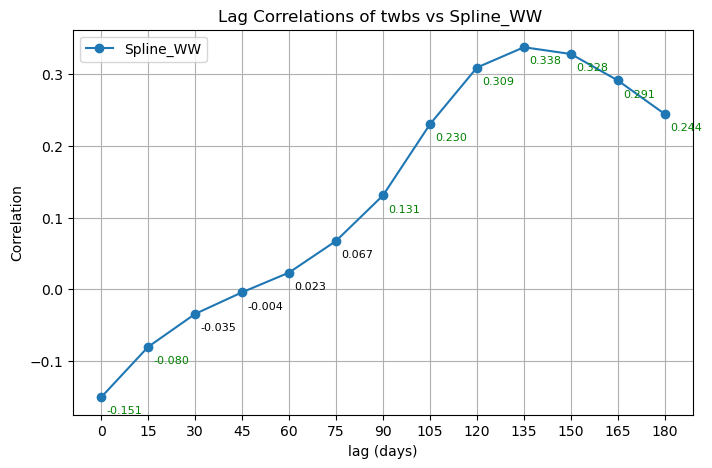

Top lags: [120, 135, 150]


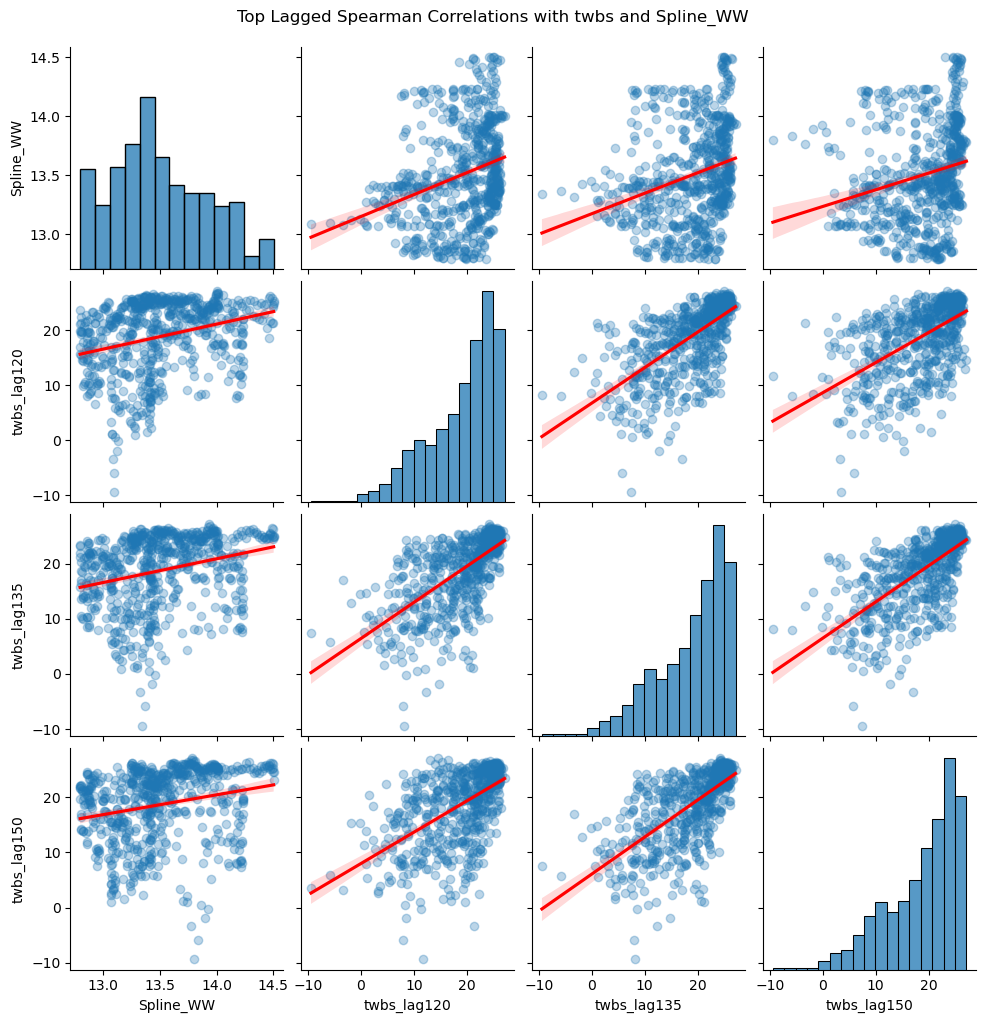

Shapiro-Wilk p-value: 1.9915528068476183e-28
{'0 days': 0, '15 days': 15, '30 days': 30, '45 days': 45, '60 days': 60, '75 days': 75, '90 days': 90, '105 days': 105, '120 days': 120, '135 days': 135, '150 days': 150, '165 days': 165, '180 days': 180}
df_merged 2020-07-06 00:00:00 to 2022-04-25 00:00:00
Index(['ppt', 'tmean', 'twbs', 'Spline_WW', 'Spline_PR', 'twbs_lag0',
       'twbs_lag15', 'twbs_lag30', 'twbs_lag45', 'twbs_lag60', 'twbs_lag75',
       'twbs_lag90', 'twbs_lag105', 'twbs_lag120', 'twbs_lag135',
       'twbs_lag150', 'twbs_lag165', 'twbs_lag180'],
      dtype='object')
Lag 0 days:
  Spline_PR: r = 0.016, p = 0.689
Lag 15 days:
  Spline_PR: r = 0.105, p = 0.007
Lag 30 days:
  Spline_PR: r = 0.142, p = 0.000
Lag 45 days:
  Spline_PR: r = 0.130, p = 0.001
Lag 60 days:
  Spline_PR: r = 0.091, p = 0.019
Lag 75 days:
  Spline_PR: r = 0.060, p = 0.125
Lag 90 days:
  Spline_PR: r = 0.045, p = 0.249
Lag 105 days:
  Spline_PR: r = 0.083, p = 0.033
Lag 120 days:
  Spline_PR: r = 0

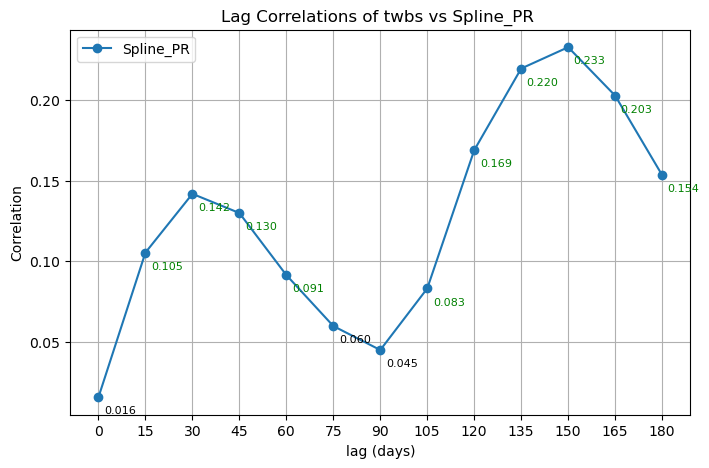

Top lags: []


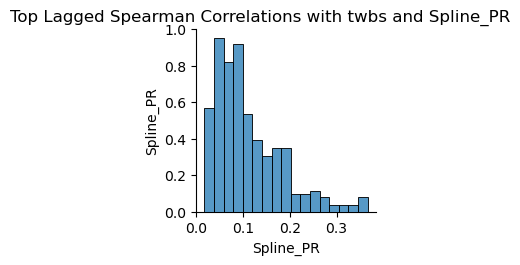

In [224]:
plot_lagged_correlations(df_tmean_ppt_twbs_covid, 'twbs', 'Spline_WW', interval_size=15, number_of_intervals=12)
plot_lagged_correlations(df_tmean_ppt_twbs_covid, 'twbs', 'Spline_PR', interval_size=15, number_of_intervals=12)

Shapiro-Wilk p-value: 3.6716813316999714e-55
{'0 days': 0, '10 days': 10, '20 days': 20, '30 days': 30, '40 days': 40, '50 days': 50, '60 days': 60, '70 days': 70, '80 days': 80, '90 days': 90, '100 days': 100, '110 days': 110, '120 days': 120, '130 days': 130, '140 days': 140, '150 days': 150}
df_merged 2020-07-06 00:00:00 to 2022-04-25 00:00:00
Index(['ppt', 'tmean', 'twbs', 'Spline_WW', 'Spline_PR', 'ppt_lag0',
       'ppt_lag10', 'ppt_lag20', 'ppt_lag30', 'ppt_lag40', 'ppt_lag50',
       'ppt_lag60', 'ppt_lag70', 'ppt_lag80', 'ppt_lag90', 'ppt_lag100',
       'ppt_lag110', 'ppt_lag120', 'ppt_lag130', 'ppt_lag140', 'ppt_lag150'],
      dtype='object')
Lag 0 days:
  Spline_WW: r = -0.069, p = 0.075
Lag 10 days:
  Spline_WW: r = -0.035, p = 0.366
Lag 20 days:
  Spline_WW: r = -0.012, p = 0.758
Lag 30 days:
  Spline_WW: r = 0.003, p = 0.945
Lag 40 days:
  Spline_WW: r = 0.035, p = 0.376
Lag 50 days:
  Spline_WW: r = 0.047, p = 0.230
Lag 60 days:
  Spline_WW: r = 0.058, p = 0.139
Lag 70

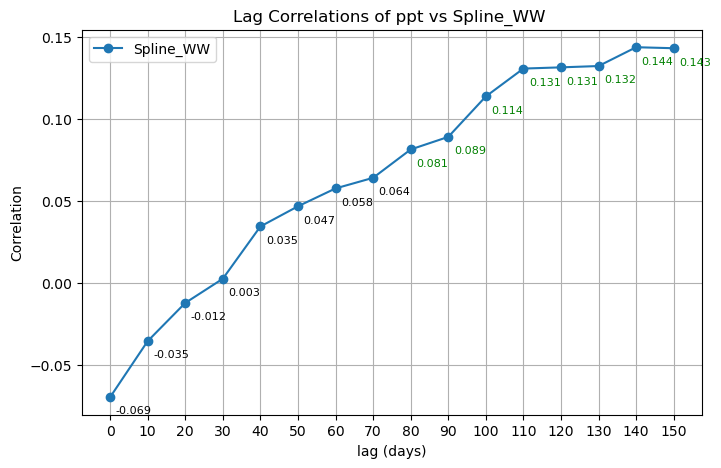

Top lags: []


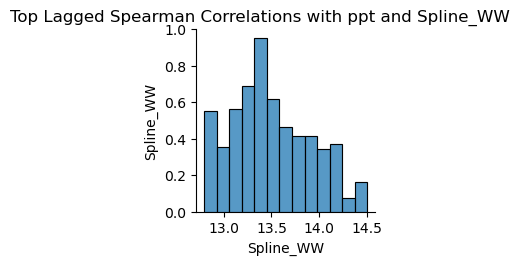

Shapiro-Wilk p-value: 3.6716813316999714e-55
{'0 days': 0, '10 days': 10, '20 days': 20, '30 days': 30, '40 days': 40, '50 days': 50, '60 days': 60, '70 days': 70, '80 days': 80, '90 days': 90, '100 days': 100, '110 days': 110, '120 days': 120, '130 days': 130, '140 days': 140, '150 days': 150}
df_merged 2020-07-06 00:00:00 to 2022-04-25 00:00:00
Index(['ppt', 'tmean', 'twbs', 'Spline_WW', 'Spline_PR', 'ppt_lag0',
       'ppt_lag10', 'ppt_lag20', 'ppt_lag30', 'ppt_lag40', 'ppt_lag50',
       'ppt_lag60', 'ppt_lag70', 'ppt_lag80', 'ppt_lag90', 'ppt_lag100',
       'ppt_lag110', 'ppt_lag120', 'ppt_lag130', 'ppt_lag140', 'ppt_lag150'],
      dtype='object')
Lag 0 days:
  Spline_PR: r = -0.019, p = 0.619
Lag 10 days:
  Spline_PR: r = -0.020, p = 0.613
Lag 20 days:
  Spline_PR: r = 0.006, p = 0.872
Lag 30 days:
  Spline_PR: r = -0.001, p = 0.970
Lag 40 days:
  Spline_PR: r = 0.016, p = 0.676
Lag 50 days:
  Spline_PR: r = 0.021, p = 0.589
Lag 60 days:
  Spline_PR: r = 0.019, p = 0.619
Lag 70

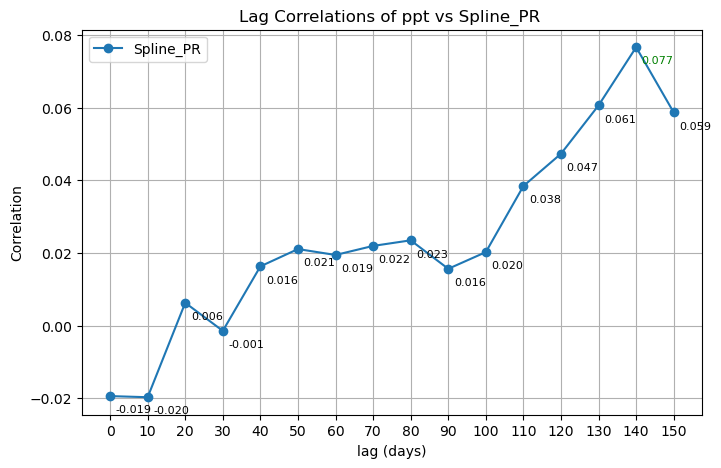

Top lags: []


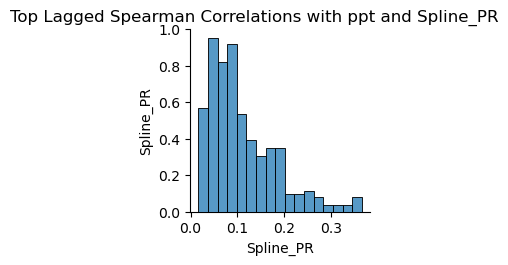

In [225]:
plot_lagged_correlations(df_tmean_ppt_twbs_covid, 'ppt', 'Spline_WW', interval_size=10, number_of_intervals=15)
plot_lagged_correlations(df_tmean_ppt_twbs_covid, 'ppt', 'Spline_PR', interval_size=10, number_of_intervals=15)

Shapiro-Wilk p-value: 6.63102058057262e-22
{'0 days': 0, '15 days': 15, '30 days': 30, '45 days': 45, '60 days': 60, '75 days': 75, '90 days': 90, '105 days': 105, '120 days': 120, '135 days': 135, '150 days': 150, '165 days': 165, '180 days': 180}
df_merged 2020-07-06 00:00:00 to 2022-04-25 00:00:00
Index(['ppt', 'tmean', 'twbs', 'Spline_WW', 'Spline_PR', 'tmean_lag0',
       'tmean_lag15', 'tmean_lag30', 'tmean_lag45', 'tmean_lag60',
       'tmean_lag75', 'tmean_lag90', 'tmean_lag105', 'tmean_lag120',
       'tmean_lag135', 'tmean_lag150', 'tmean_lag165', 'tmean_lag180'],
      dtype='object')
Lag 0 days:
  Spline_WW: r = -0.174, p = 0.000
Lag 15 days:
  Spline_WW: r = -0.104, p = 0.007
Lag 30 days:
  Spline_WW: r = -0.047, p = 0.231
Lag 45 days:
  Spline_WW: r = -0.018, p = 0.641
Lag 60 days:
  Spline_WW: r = 0.014, p = 0.714
Lag 75 days:
  Spline_WW: r = 0.061, p = 0.120
Lag 90 days:
  Spline_WW: r = 0.132, p = 0.001
Lag 105 days:
  Spline_WW: r = 0.238, p = 0.000
Lag 120 days:
  S

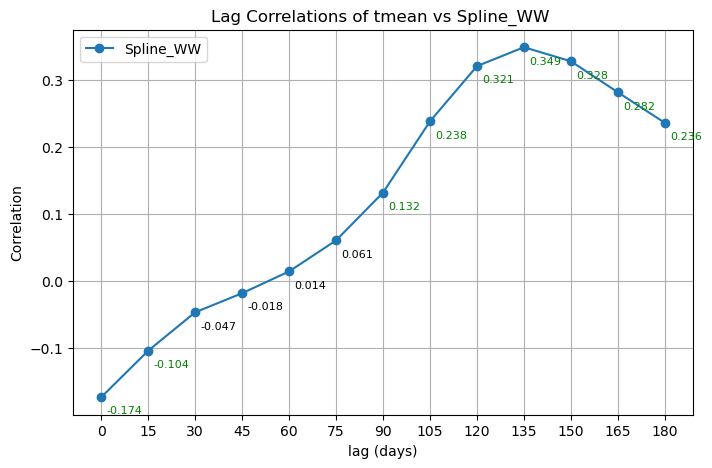

Top lags: [120, 135, 150]


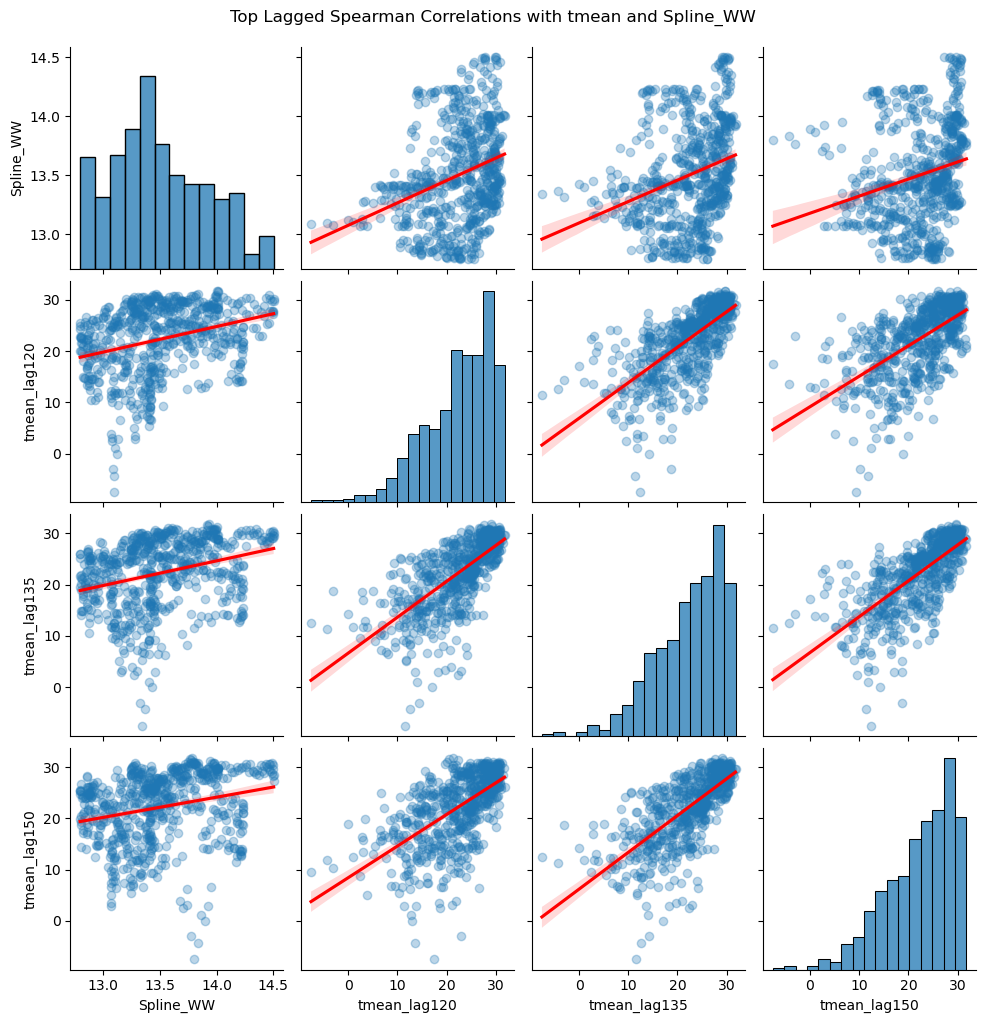

Shapiro-Wilk p-value: 6.63102058057262e-22
{'0 days': 0, '15 days': 15, '30 days': 30, '45 days': 45, '60 days': 60, '75 days': 75, '90 days': 90, '105 days': 105, '120 days': 120, '135 days': 135, '150 days': 150, '165 days': 165, '180 days': 180}
df_merged 2020-07-06 00:00:00 to 2022-04-25 00:00:00
Index(['ppt', 'tmean', 'twbs', 'Spline_WW', 'Spline_PR', 'tmean_lag0',
       'tmean_lag15', 'tmean_lag30', 'tmean_lag45', 'tmean_lag60',
       'tmean_lag75', 'tmean_lag90', 'tmean_lag105', 'tmean_lag120',
       'tmean_lag135', 'tmean_lag150', 'tmean_lag165', 'tmean_lag180'],
      dtype='object')
Lag 0 days:
  Spline_PR: r = 0.001, p = 0.981
Lag 15 days:
  Spline_PR: r = 0.073, p = 0.063
Lag 30 days:
  Spline_PR: r = 0.119, p = 0.002
Lag 45 days:
  Spline_PR: r = 0.114, p = 0.003
Lag 60 days:
  Spline_PR: r = 0.092, p = 0.018
Lag 75 days:
  Spline_PR: r = 0.075, p = 0.056
Lag 90 days:
  Spline_PR: r = 0.066, p = 0.091
Lag 105 days:
  Spline_PR: r = 0.115, p = 0.003
Lag 120 days:
  Splin

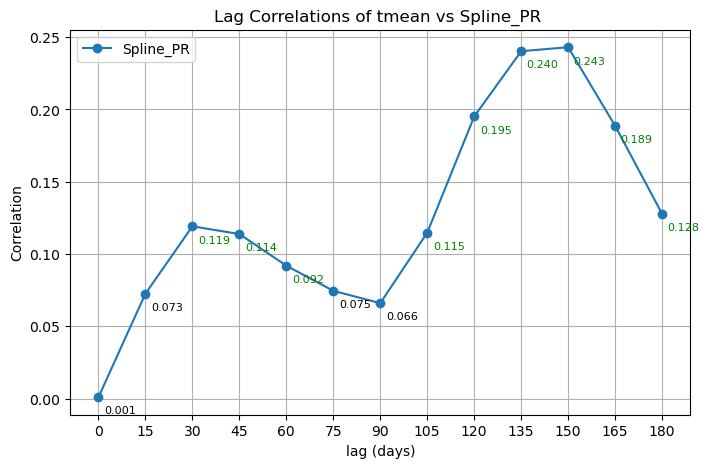

Top lags: []


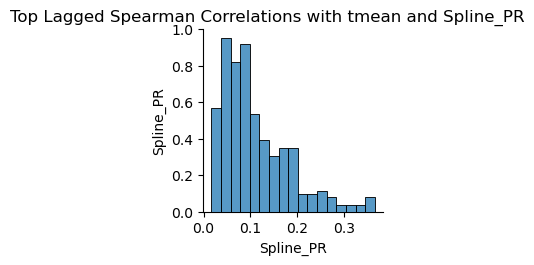

In [226]:
plot_lagged_correlations(df_tmean_ppt_twbs_covid, 'tmean', 'Spline_WW', interval_size=15, number_of_intervals=12)
plot_lagged_correlations(df_tmean_ppt_twbs_covid, 'tmean', 'Spline_PR', interval_size=15, number_of_intervals=12)

# Correlation Analysis with differenced data

Shapiro-Wilk p-value: 3.294085722414212e-06
{'0 days': 0, '15 days': 15, '30 days': 30, '45 days': 45, '60 days': 60, '75 days': 75, '90 days': 90, '105 days': 105, '120 days': 120, '135 days': 135, '150 days': 150, '165 days': 165, '180 days': 180}
df_merged 2020-09-28 00:00:00 to 2022-04-25 00:00:00
Index(['ppt', 'tmean', 'twbs', 'Spline_WW', 'Spline_PR', 'tmean_differenced',
       'tmean_differenced_lag0', 'tmean_differenced_lag15',
       'tmean_differenced_lag30', 'tmean_differenced_lag45',
       'tmean_differenced_lag60', 'tmean_differenced_lag75',
       'tmean_differenced_lag90', 'tmean_differenced_lag105',
       'tmean_differenced_lag120', 'tmean_differenced_lag135',
       'tmean_differenced_lag150', 'tmean_differenced_lag165',
       'tmean_differenced_lag180'],
      dtype='object')
Lag 0 days:
  Spline_WW: r = -0.215, p = 0.000
Lag 15 days:
  Spline_WW: r = -0.150, p = 0.000
Lag 30 days:
  Spline_WW: r = -0.120, p = 0.004
Lag 45 days:
  Spline_WW: r = -0.088, p = 0.035


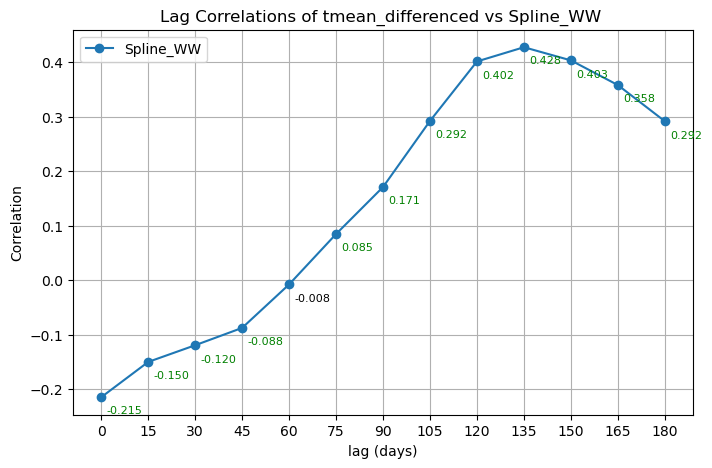

Top lags: [120, 135, 150, 165]


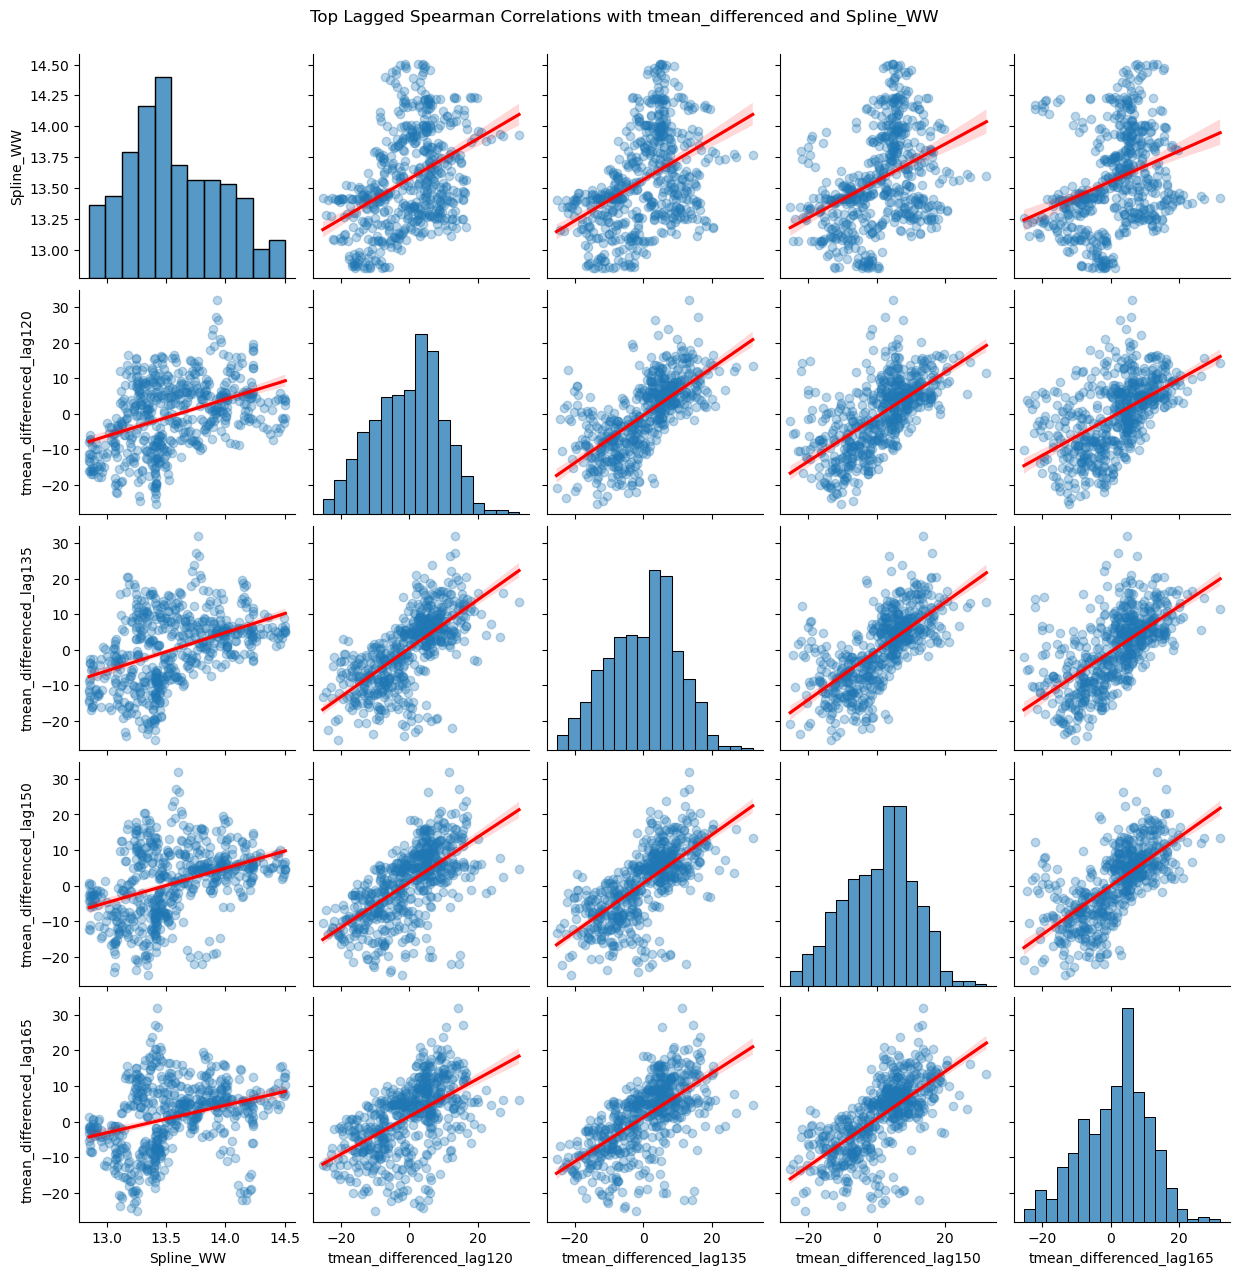

In [27]:
df_tmean_ppt_twbs_covid_diff = df_tmean_ppt_twbs_covid.copy()
df_tmean_ppt_twbs_covid_diff['tmean_differenced'] = df_tmean_ppt_twbs_covid_diff['tmean'].diff(periods=365/4)
# df_tmean_ppt_twbs_covid_diff['Spline_WW_differenced'] = df_tmean_ppt_twbs_covid_diff['Spline_WW'].diff()
df_tmean_ppt_twbs_covid_diff = df_tmean_ppt_twbs_covid_diff.dropna(subset=['tmean_differenced'])
plot_lagged_correlations(df_tmean_ppt_twbs_covid_diff, 'tmean_differenced', 'Spline_WW', interval_size=15, number_of_intervals=12)
# plot_lagged_correlations(df_tmean_ppt_twbs_covid_diff, 'twbs_differenced', 'Spline_PR', interval_size=15, number_of_intervals=12)

# Correlation Analysis with seasonal and annual cycle

In [20]:
from scipy import signal
def remove_dominant_signals(array_in, spd, fCrit):
    '''
        This function removes the dominant signal be removing the long-term linear trend,
        preserving the mean and removing signals less than a critical threshold frequency.

        Inputs:
            array_in - array of shape(nt, nx, ny)
            spd - samples per day
            fCrit - critical frequency at which to run the high-bandpass filter

        Returns:
            array_dt - array with dominant signals removed, of shape (nt, nx, ny)

    '''
    nt, nx, ny = array_in.shape

    # Remove the long term trend
    long_mean = np.mean(array_in, axis = 0)
    detrend = signal.detrend(array_in, axis = 0, type='linear')
    # Conserve the mean
    array_dt = detrend + long_mean

    # Remove seasonal and longer signals, preserving the subseasonal signal (1st three harmonics)
    fourier = np.fft.fft(array_dt, axis = 0)
    fourier_mean = np.copy(fourier[0,:,:])
    freq = np.fft.fftfreq(nt, 1./spd)
    ind = np.where(np.abs(freq)<=(fCrit*3))[0]
    fourier[ind,:,:] = 0.0
    # Preserve the mean
    fourier[0,:,:] = fourier_mean
    array_dt = np.fft.ifft(fourier, axis = 0)

    print("Original mean:", np.mean(array_in))
    print("Filtered mean:", np.mean(array_dt))
    print("Original variance:", np.var(array_in))
    print("Filtered variance:", np.var(array_dt))


    return array_dt

Original mean: 21.728543074079443
Filtered mean: (21.728543074079436+3.552181744428675e-16j)
Original variance: 55.76779735291014
Filtered variance: 16.114125304853843
Shapiro-Wilk p-value: 8.078935814707141e-13
{'0 days': 0, '15 days': 15, '30 days': 30, '45 days': 45, '60 days': 60, '75 days': 75, '90 days': 90, '105 days': 105, '120 days': 120, '135 days': 135, '150 days': 150, '165 days': 165, '180 days': 180}
df_merged 2020-07-06 00:00:00 to 2022-04-25 00:00:00
Index(['ppt', 'tmean', 'twbs', 'Spline_WW', 'Spline_PR', 'tmean_filtered',
       'tmean_filtered_lag0', 'tmean_filtered_lag15', 'tmean_filtered_lag30',
       'tmean_filtered_lag45', 'tmean_filtered_lag60', 'tmean_filtered_lag75',
       'tmean_filtered_lag90', 'tmean_filtered_lag105',
       'tmean_filtered_lag120', 'tmean_filtered_lag135',
       'tmean_filtered_lag150', 'tmean_filtered_lag165',
       'tmean_filtered_lag180'],
      dtype='object')
Lag 0 days:
  Spline_WW: r = 0.054, p = 0.166
Lag 15 days:
  Spline_WW: 

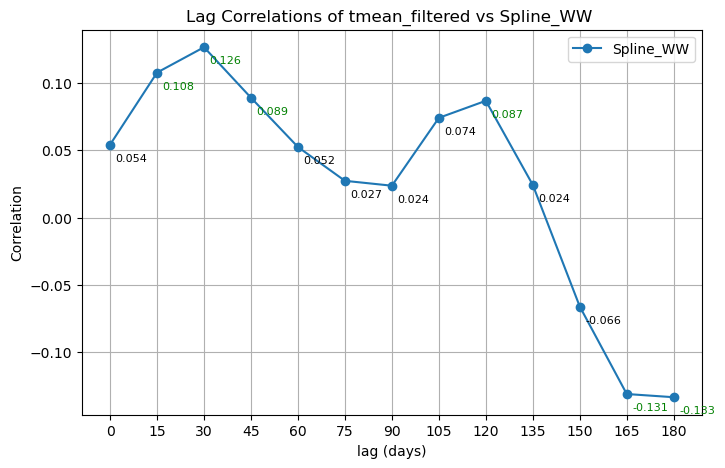

Top lags: []


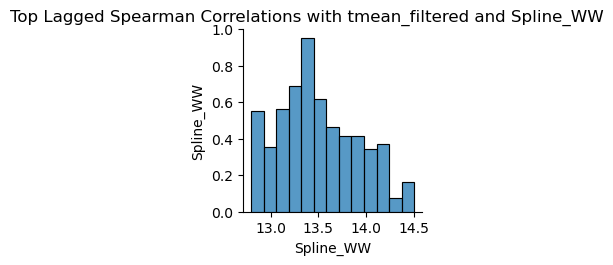

In [25]:
import numpy as np
df_tmean_ppt_twbs_covid_copy = df_tmean_ppt_twbs_covid.copy()

array_1d = df_tmean_ppt_twbs_covid_copy['tmean'].values
array_3d = array_1d.reshape(-1, 1, 1)  # shape (nt, 1, 1)

spd = 1  # samples per day
# remove seasonal and annual cycle 
fCrit = 1/1095

filtered_array_3d = remove_dominant_signals(array_3d, spd, fCrit)

filtered_twbs = np.real(filtered_array_3d).flatten()

df_tmean_ppt_twbs_covid_copy['tmean_filtered'] = filtered_twbs

# df_tmean_ppt_twbs_covid_diff['Spline_WW_differenced'] = df_tmean_ppt_twbs_covid_diff['Spline_WW'].diff()
df_tmean_ppt_twbs_covid_copy = df_tmean_ppt_twbs_covid_copy.dropna(subset=['tmean_filtered'])
plot_lagged_correlations(df_tmean_ppt_twbs_covid_copy, 'tmean_filtered', 'Spline_WW', interval_size=15, number_of_intervals=12)
# plot_lagged_correlations(df_tmean_ppt_twbs_covid_diff, 'twbs_differenced', 'Spline_PR', interval_size=15, number_of_intervals=12)

# Correlation Analysis with AR prewhitened data

In [136]:
# /home/sd96/rdf/twbs/netcdf/Harris_County_PRISM_twbs_stable_4kmD2_2020_2023_whitened_AR_3.nc
import pandas as pd
import os
import xarray as xr
home = '/home/sd96/rdf'
variables = ['tmean'] 
var = 'tmean'
years = ['2020', '2021', '2022', '2023'] 
daily = "D2"
lag = 3
path = os.path.join(home, var, 'netcdf', f'Harris_County_PRISM_{var}_stable_4kmD2_2020_2023_whitened_AR_{lag}.nc')

# df_tmean_ppt_twbs = None
# for var in variables: 

#     var = xr.open_dataset(paths[var])
#     df_var = var.to_dataframe()

#     if df_tmean_ppt_twbs is None:
#         df_tmean_ppt_twbs = df_var
#     else:
#         df_tmean_ppt_twbs = df_tmean_ppt_twbs.join(df_var, how='outer')

ds = xr.open_dataset(path)
df_var = ds.to_dataframe()

print(f"{var}:", df_var.index.min(), "to", df_var.index.max())
print(df_var.columns)

# Load and create covid df
df_covid_full = pd.read_csv(
   os.path.join(home, "sarscov2ww_ricehhd.csv")
)

df_covid_full.rename(columns={'date': 'Date'}, inplace=True)
df_covid_full['Date'] = pd.to_datetime(df_covid_full['Date'])

# Save total Column and drop the column name
df_covid = df_covid_full[df_covid_full['WWTP'] == 'TOTAL']
df_covid = df_covid[['Date', 'Spline_WW', 'Spline_PR']]

df_covid.set_index('Date', inplace=True)
df_covid.index = pd.to_datetime(df_covid.index)
df_var.index = pd.to_datetime(df_var.index)

print("COVID:", df_covid.index.min(), "to", df_covid.index.max())

df_var_covid = df_covid.join(df_var, how='left')

print("df_var_covid", df_var_covid.index.min(), "to", df_var_covid.index.max())
print(df_var_covid.columns)

tmean: 2020-01-04 00:00:00 to 2023-12-31 00:00:00
Index(['whitened_tmean_AR(3)'], dtype='object')


/tmp/ipykernel_25469/1813259313.py:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_covid_full['Date'] = pd.to_datetime(df_covid_full['Date'])


COVID: 2020-07-06 00:00:00 to 2022-04-25 00:00:00
df_var_covid 2020-07-06 00:00:00 to 2022-04-25 00:00:00
Index(['Spline_WW', 'Spline_PR', 'whitened_tmean_AR(3)'], dtype='object')


Shapiro-Wilk p-value: 4.4109617136995505e-18
{'0 days': 0, '15 days': 15, '30 days': 30, '45 days': 45, '60 days': 60, '75 days': 75, '90 days': 90, '105 days': 105, '120 days': 120, '135 days': 135, '150 days': 150, '165 days': 165, '180 days': 180, '195 days': 195, '210 days': 210, '225 days': 225}
df_merged 2021-02-16 00:00:00 to 2022-04-25 00:00:00
Index(['Spline_WW', 'Spline_PR', 'whitened_tmean_AR(3)',
       'whitened_tmean_AR(3)_lag0', 'whitened_tmean_AR(3)_lag15',
       'whitened_tmean_AR(3)_lag30', 'whitened_tmean_AR(3)_lag45',
       'whitened_tmean_AR(3)_lag60', 'whitened_tmean_AR(3)_lag75',
       'whitened_tmean_AR(3)_lag90', 'whitened_tmean_AR(3)_lag105',
       'whitened_tmean_AR(3)_lag120', 'whitened_tmean_AR(3)_lag135',
       'whitened_tmean_AR(3)_lag150', 'whitened_tmean_AR(3)_lag165',
       'whitened_tmean_AR(3)_lag180', 'whitened_tmean_AR(3)_lag195',
       'whitened_tmean_AR(3)_lag210', 'whitened_tmean_AR(3)_lag225'],
      dtype='object')
Lag 0 days:
  Spline_

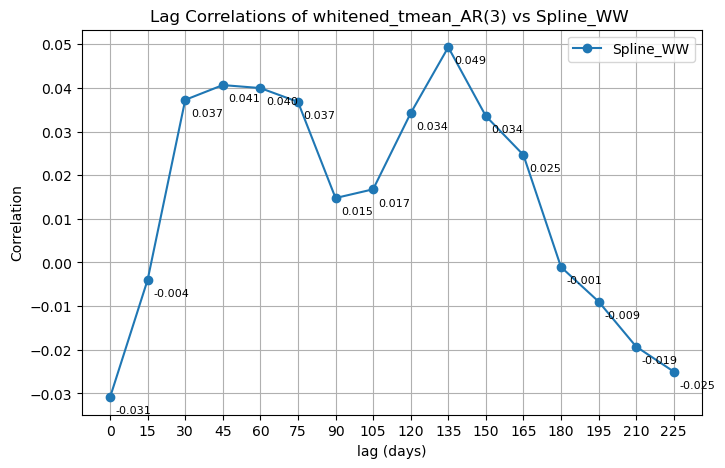

Top lags: []


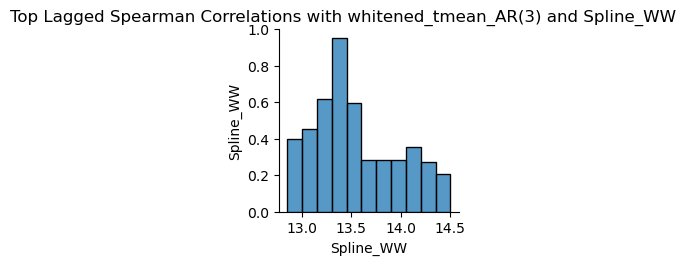

In [137]:
int_size = 15
num_ints = 15
plot_lagged_correlations(df_var_covid, f'whitened_{var}_AR({lag})', 'Spline_WW', 
                         interval_size=int_size, number_of_intervals=num_ints)

# Prewhiten data

## Constants

In [1]:
import os 
import xarray as xr 
import numpy as np 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

In [2]:
home = '/home/sd96/rdf'
shapefile = os.path.join(home, 'tl_2024_us_state', 'tl_2024_us_state.shp')

In [3]:
variables = ['ppt', 'tmean', 'tdmean', 'hurs', 'twbs'] 
years = ['2020', '2021', '2022', '2023'] 
daily = "D2"

## Combine weather arrays from 2020 to 2023

In [4]:
def weighted_mean(ds, lat_name, lon_name): 
    lats = ds[lat_name]
    weights = np.cos(np.deg2rad(lats)) 
    weights.name = "weights"

    ds_weighted = ds.weighted(weights) 
    ds_weighted_mean = ds_weighted.mean([lon_name, lat_name]) 

    return ds_weighted_mean 

In [5]:
# Go through each variable and create nc file for 2020-2025
for i, var in enumerate(variables): 
    homedir = os.path.join(home, f'{var}', 'netcdf') 
    files = []
    for year in years: 
        files.append(os.path.join(home, homedir, f'Harris_County_PRISM_{var}_stable_4km{daily}_{year}.nc')) 
        
    # ds = xr.open_mfdataset(files, concat_dim = 'time', combine= 'nested').load()

    ds = xr.open_mfdataset(
            files,
            concat_dim='time',
            combine='nested',
            engine='netcdf4'  # optional but safer
        ).load()

    if 'time' in ds.sizes and ds.sizes['time'] == 366:
        ds = ds.transpose('time', 'lat', 'lon')
    
    # Get mean 
    ds_mean = weighted_mean(ds, 'lat', 'lon')

    outfile_path = os.path.join(home, homedir, f'Harris_County_PRISM_{var}_stable_4km{daily}_{years[0]}_{years[-1]}.nc') 

    ds_mean.to_netcdf(outfile_path)
    print(f"Saved file at {outfile_path}")

Saved file at /home/sd96/rdf/ppt/netcdf/Harris_County_PRISM_ppt_stable_4kmD2_2020_2023.nc
Saved file at /home/sd96/rdf/tmean/netcdf/Harris_County_PRISM_tmean_stable_4kmD2_2020_2023.nc
Saved file at /home/sd96/rdf/tdmean/netcdf/Harris_County_PRISM_tdmean_stable_4kmD2_2020_2023.nc
Saved file at /home/sd96/rdf/hurs/netcdf/Harris_County_PRISM_hurs_stable_4kmD2_2020_2023.nc
Saved file at /home/sd96/rdf/twbs/netcdf/Harris_County_PRISM_twbs_stable_4kmD2_2020_2023.nc


## Removing Mean & Autocorrelation

Removing autocorrelation using AR(1) for var twbs (/home/sd96/rdf/twbs/netcdf/Harris_County_PRISM_twbs_stable_4kmD2_2020_2023.nc)


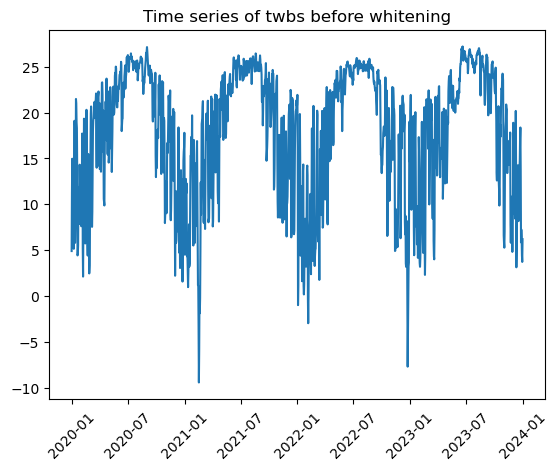

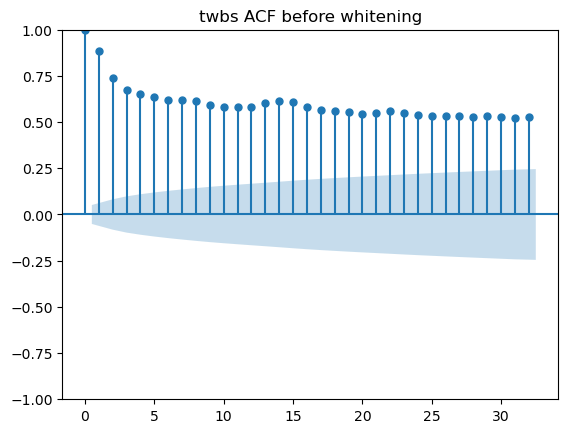

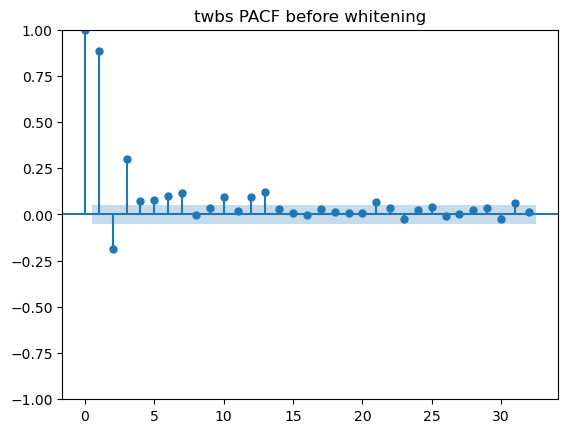

[-3.91081016 -0.95118559  0.48833987 ... -2.51535192 -1.81755129
  0.67475672]
Saved whitened array at /home/sd96/rdf/twbs/netcdf/Harris_County_PRISM_twbs_stable_4kmD2_2020_2023_whitened_AR_3.nc
<xarray.DataArray 'time' ()> Size: 8B
array('2023-12-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2023-12-31 <xarray.DataArray 'time' ()> Size: 8B
array('2020-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2020-01-01


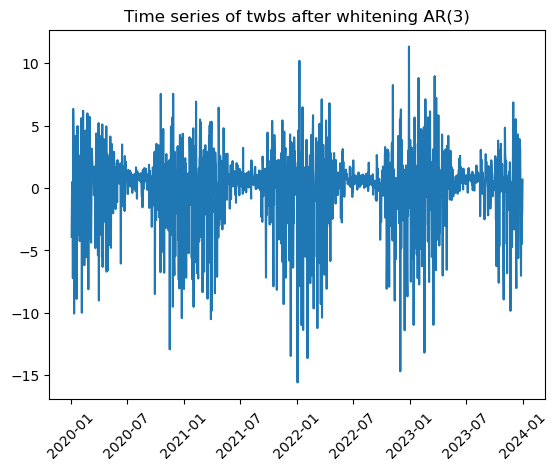

saved at plots/ACF_twbs_AR(3)


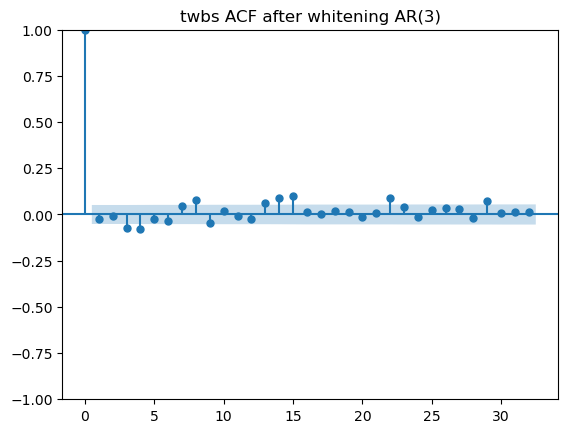

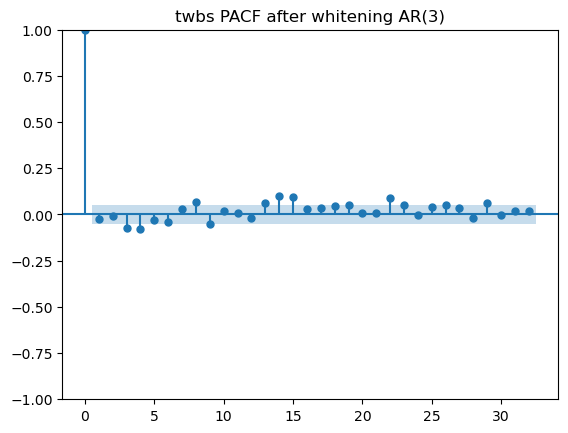

In [145]:
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acovf
from scipy.linalg import toeplitz

var = 'twbs'
file_path = os.path.join(home, var, 'netcdf' , f'Harris_County_PRISM_{var}_stable_4km{daily}_{years[0]}_{years[-1]}.nc') 

print(f"Removing autocorrelation using AR(1) for var {var} ({file_path})")

# Open file and get values 
ds = xr.open_dataset(file_path)
da = ds[var]  
ts = da.values

# Plot time series 
plt.plot(da.time, ts) 
plt.title(f"Time series of {var} before whitening")
plt.xticks(rotation=45)
plt.show()

plot_acf(ts)
plt.title(f"{var} ACF before whitening")
plt.savefig(f'plots/ACF_{var}')
plt.show()

plot_pacf(ts)
plt.title(f"{var} PACF before whitening")
plt.show()

# Fit AR model
lags=3
model = AutoReg(ts, lags=lags) 
fit = model.fit()

# Get residuals
whitened_ts = fit.resid

print(whitened_ts)
# Saving
file_path = os.path.join(home, var, 'netcdf' , f'Harris_County_PRISM_{var}_stable_4km{daily}_{years[0]}_{years[-1]}_whitened_AR_{lags}.nc') 

if os.path.exists(file_path): 
    os.remove(file_path)
    
da_whitened = xr.DataArray(
    data=whitened_ts,
    coords={"time": da.time[lags:]},
    dims="time",
    name=f"whitened_{var}_AR({lags})"
)

# Save to NetCDF
da_whitened.to_netcdf(file_path)
print(f"Saved whitened array at {file_path}")
print(max(da.time), min(da.time))


plt.plot(da.time[lags:], whitened_ts) 
plt.title(f"Time series of {var} after whitening AR({lags})")
plt.xticks(rotation=45)
plt.show()

# # Plot ACF of whitened series 
plot_acf(whitened_ts)
plt.title(f"{var} ACF after whitening AR({lags})")
plt.savefig(f'plots/ACF_{var}_AR({lags})')
print(f'saved at plots/ACF_{var}_AR({lags})')
plt.show()

plot_pacf(whitened_ts)
plt.title(f"{var} PACF after whitening AR({lags})")
plt.show()

## Plotting ACF, PACF 

In [77]:
def plot_acf_pacf(ts, var, save=True): 
    # var_label = labels.get(ds.name, ds.name) if labels else da.name

    fig, axes = plt.subplots(2, 1, figsize=(12, 14))

    # ACF
    plot_acf(ts, ax=axes[0])
    axes[0].set_title(f"Autocorrelation of {var}")
    axes[0].set_xlabel("Lag (Days)")
    axes[0].set_ylim(-1.05, 1.1)

    # PACF
    plot_pacf(ts, ax=axes[1], method='ywm')
    axes[1].set_title(f"Partial Autocorrelation of {var}")
    axes[1].set_xlabel("Lag (Days)")
    axes[1].set_ylim(-1.05, 1.05)

    if save:
        filename = f"ACF_PACF_{var}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        print(f"Plot saved at {filename}")

    plt.tight_layout()
    plt.show()

Plot saved at ACF_PACF_ppt.png


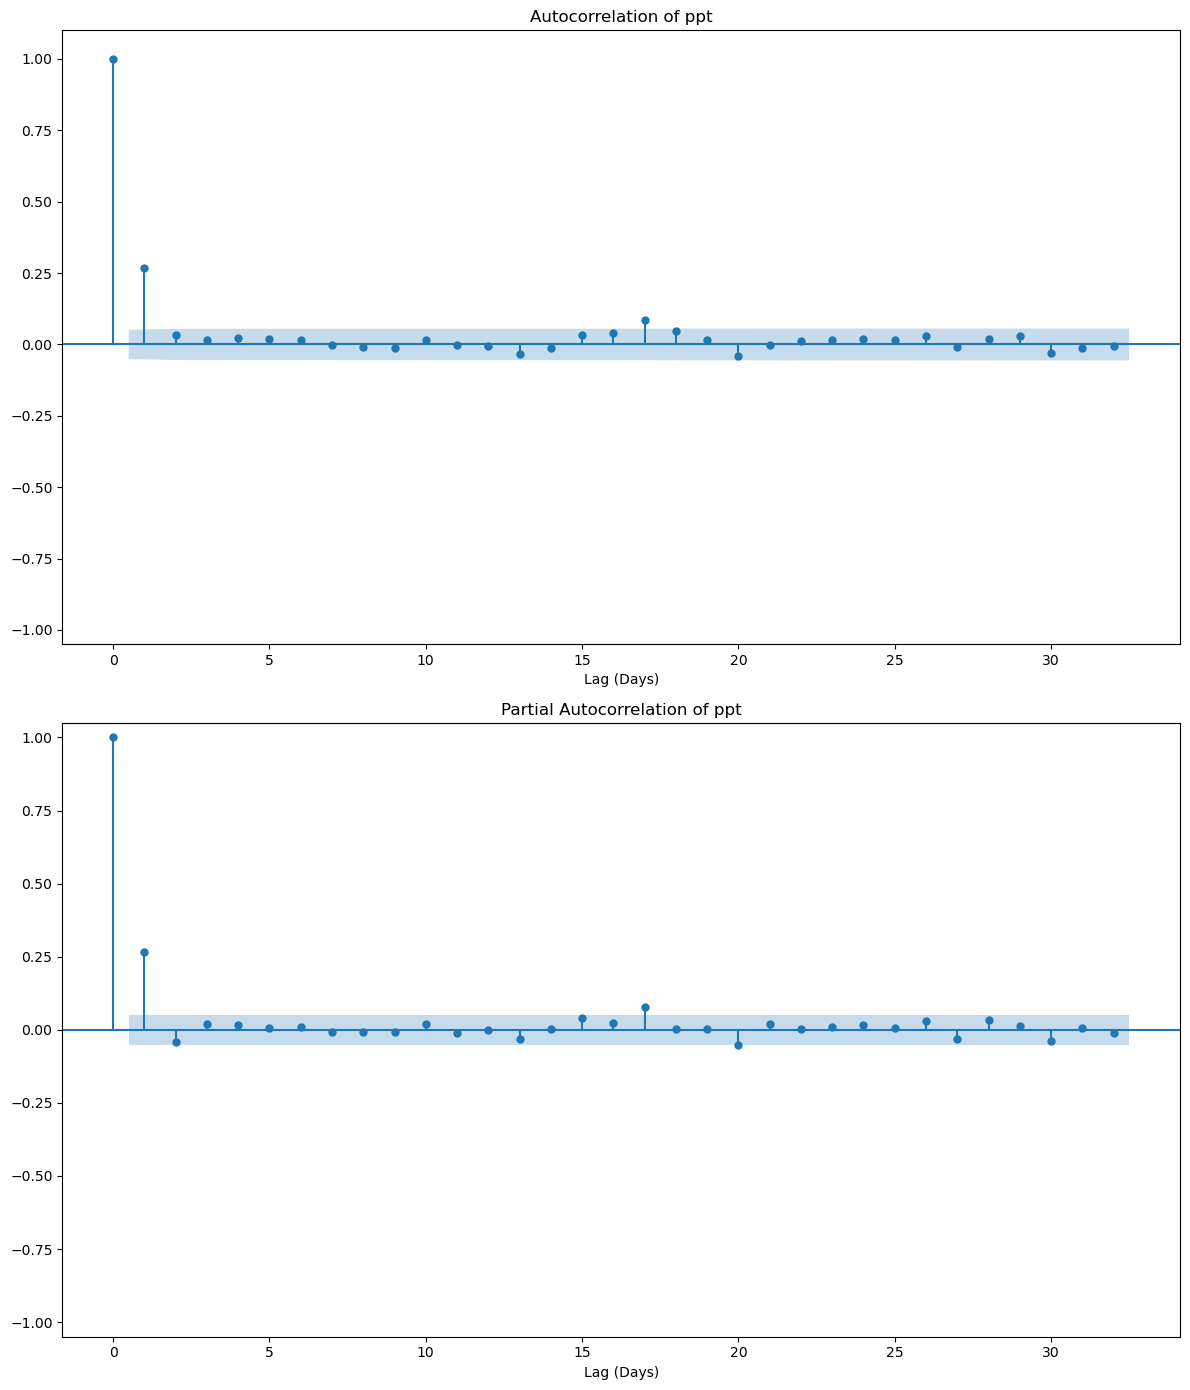

Plot saved at ACF_PACF_tmean.png


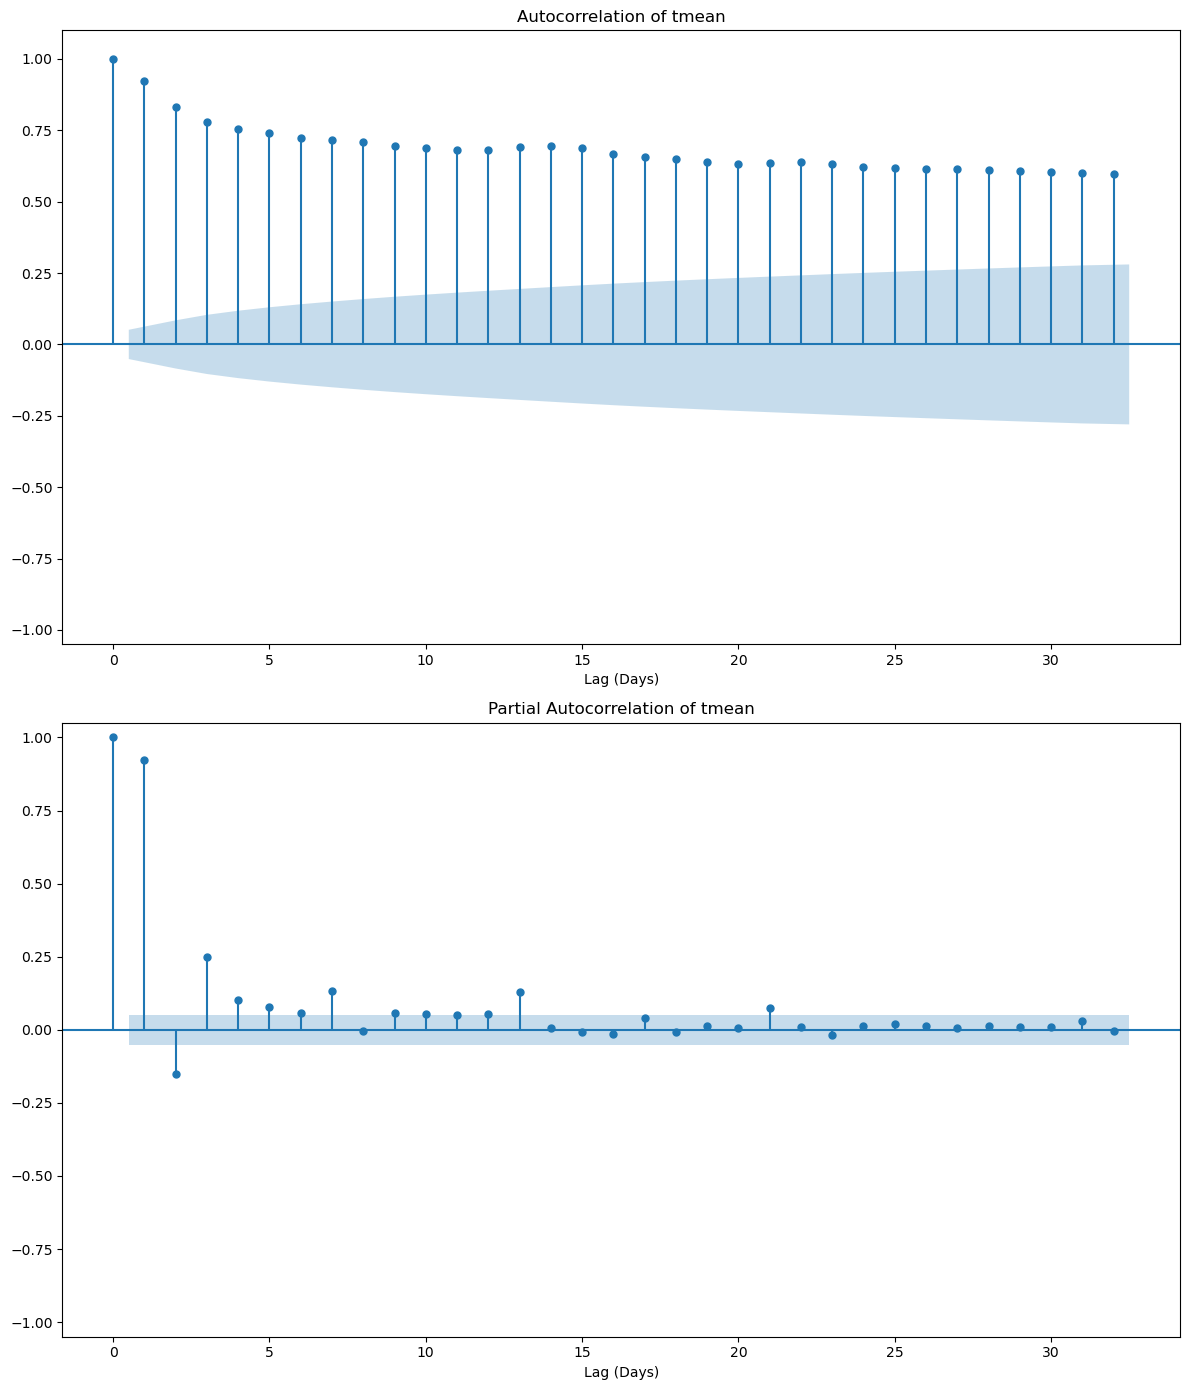

Plot saved at ACF_PACF_tdmean.png


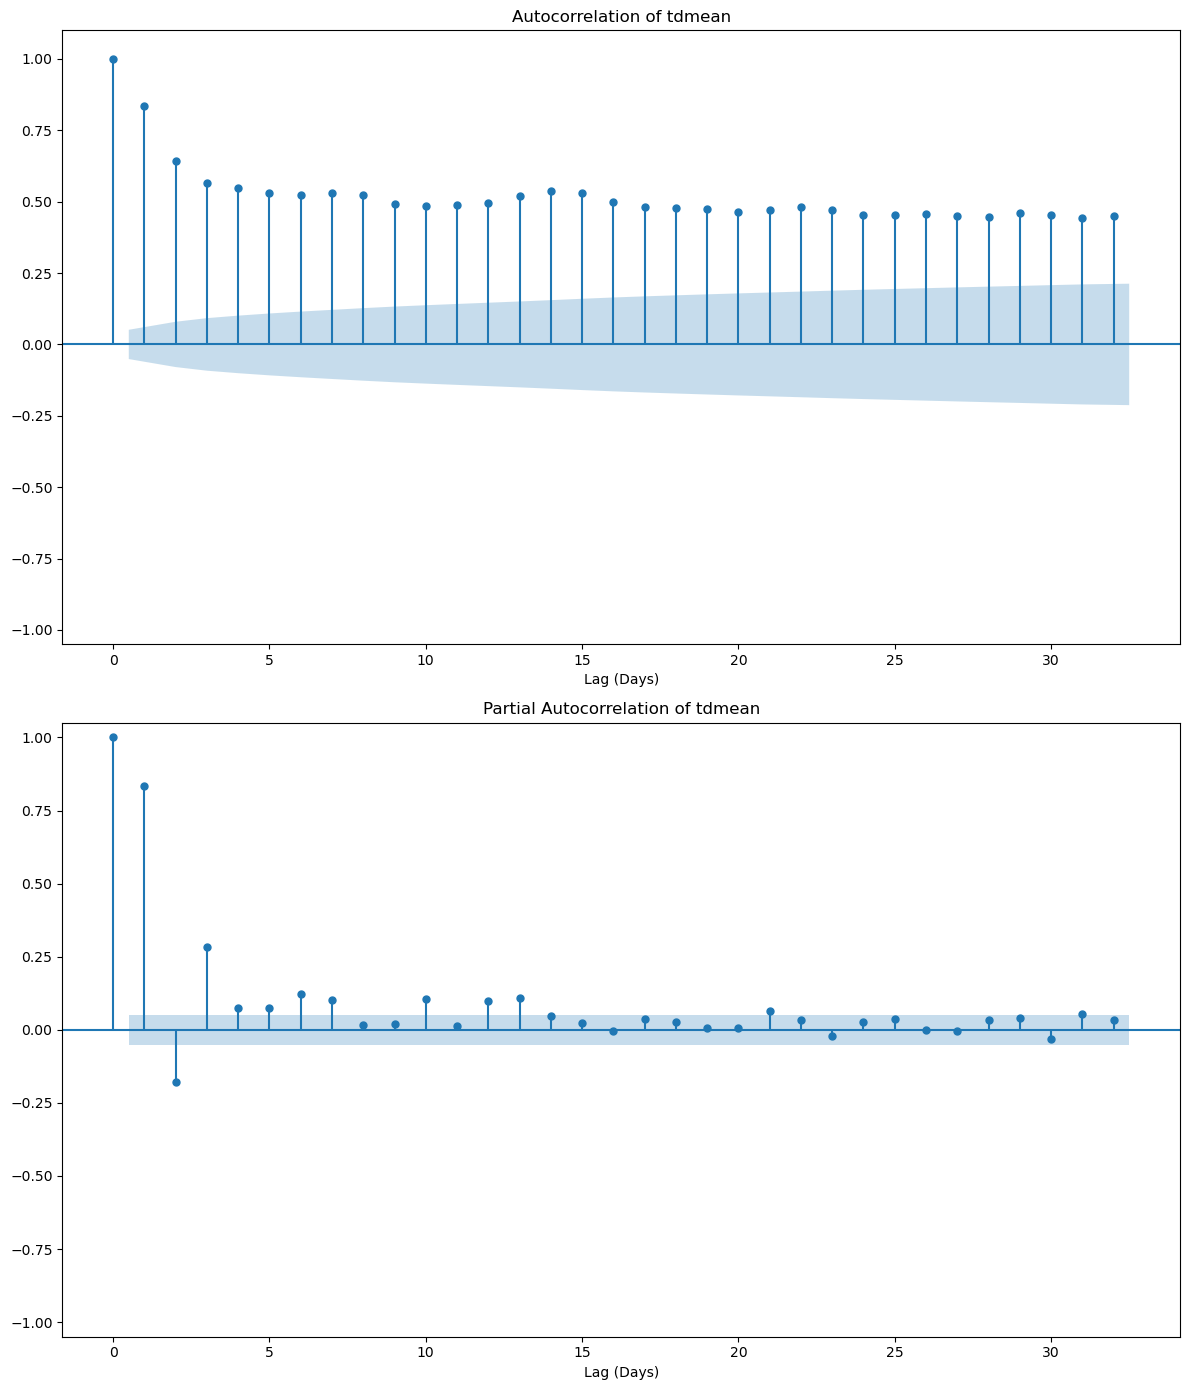

Plot saved at ACF_PACF_hurs.png


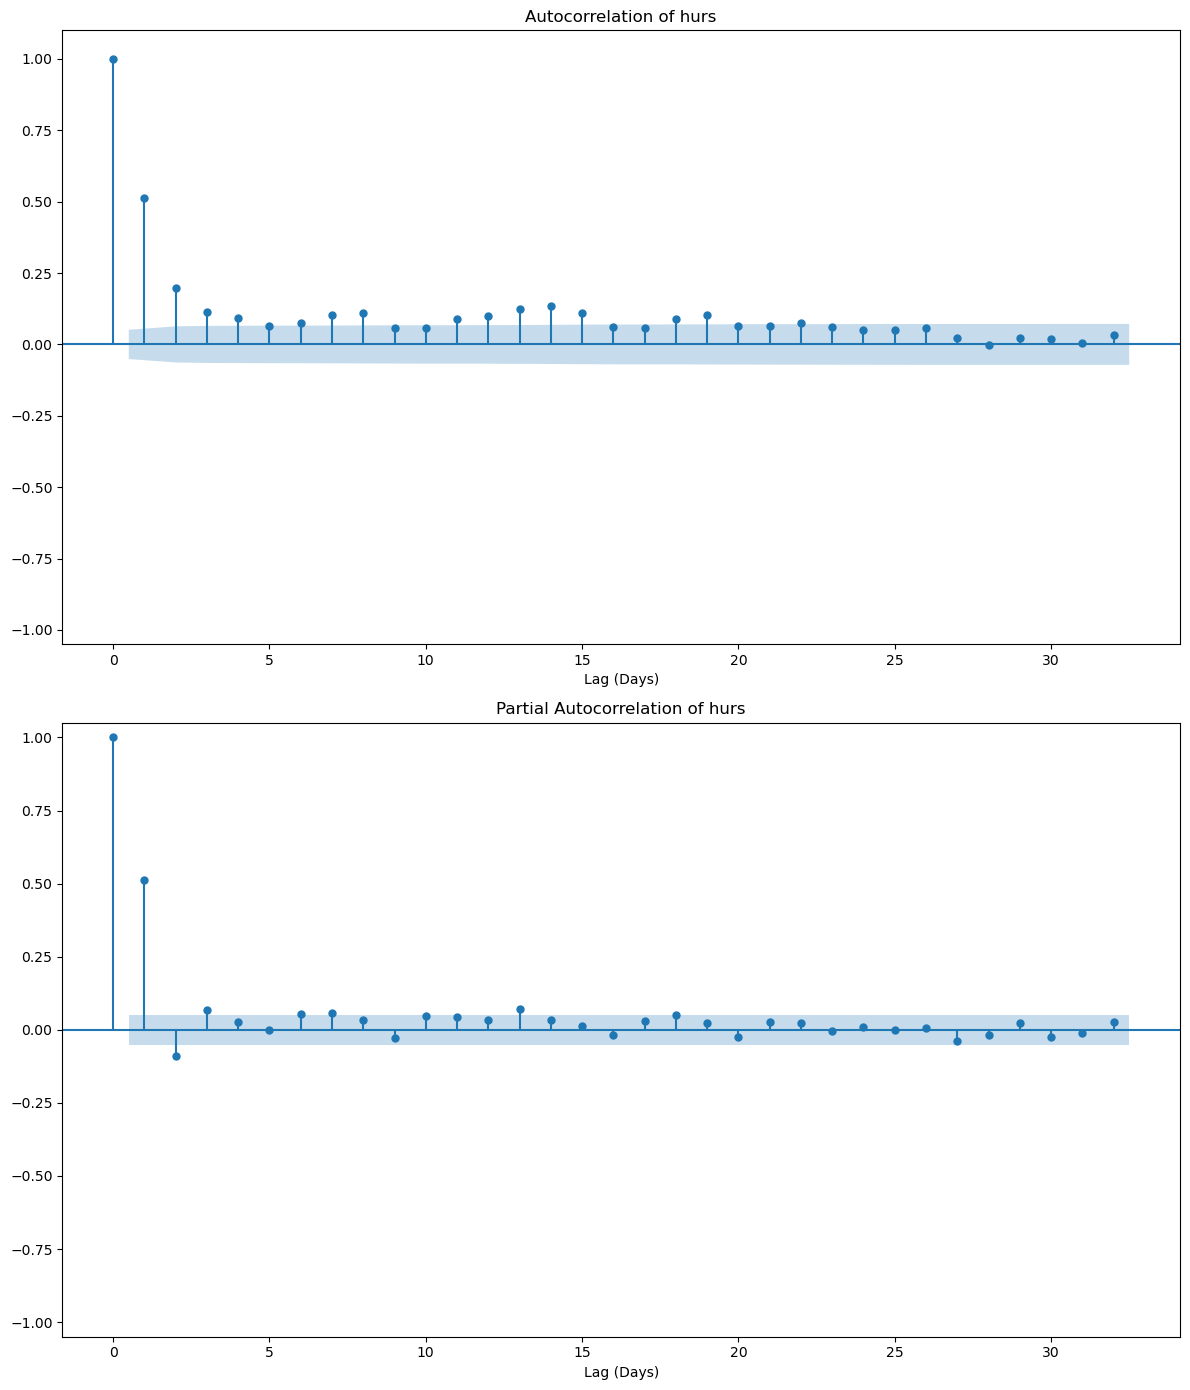

Plot saved at ACF_PACF_twbs.png


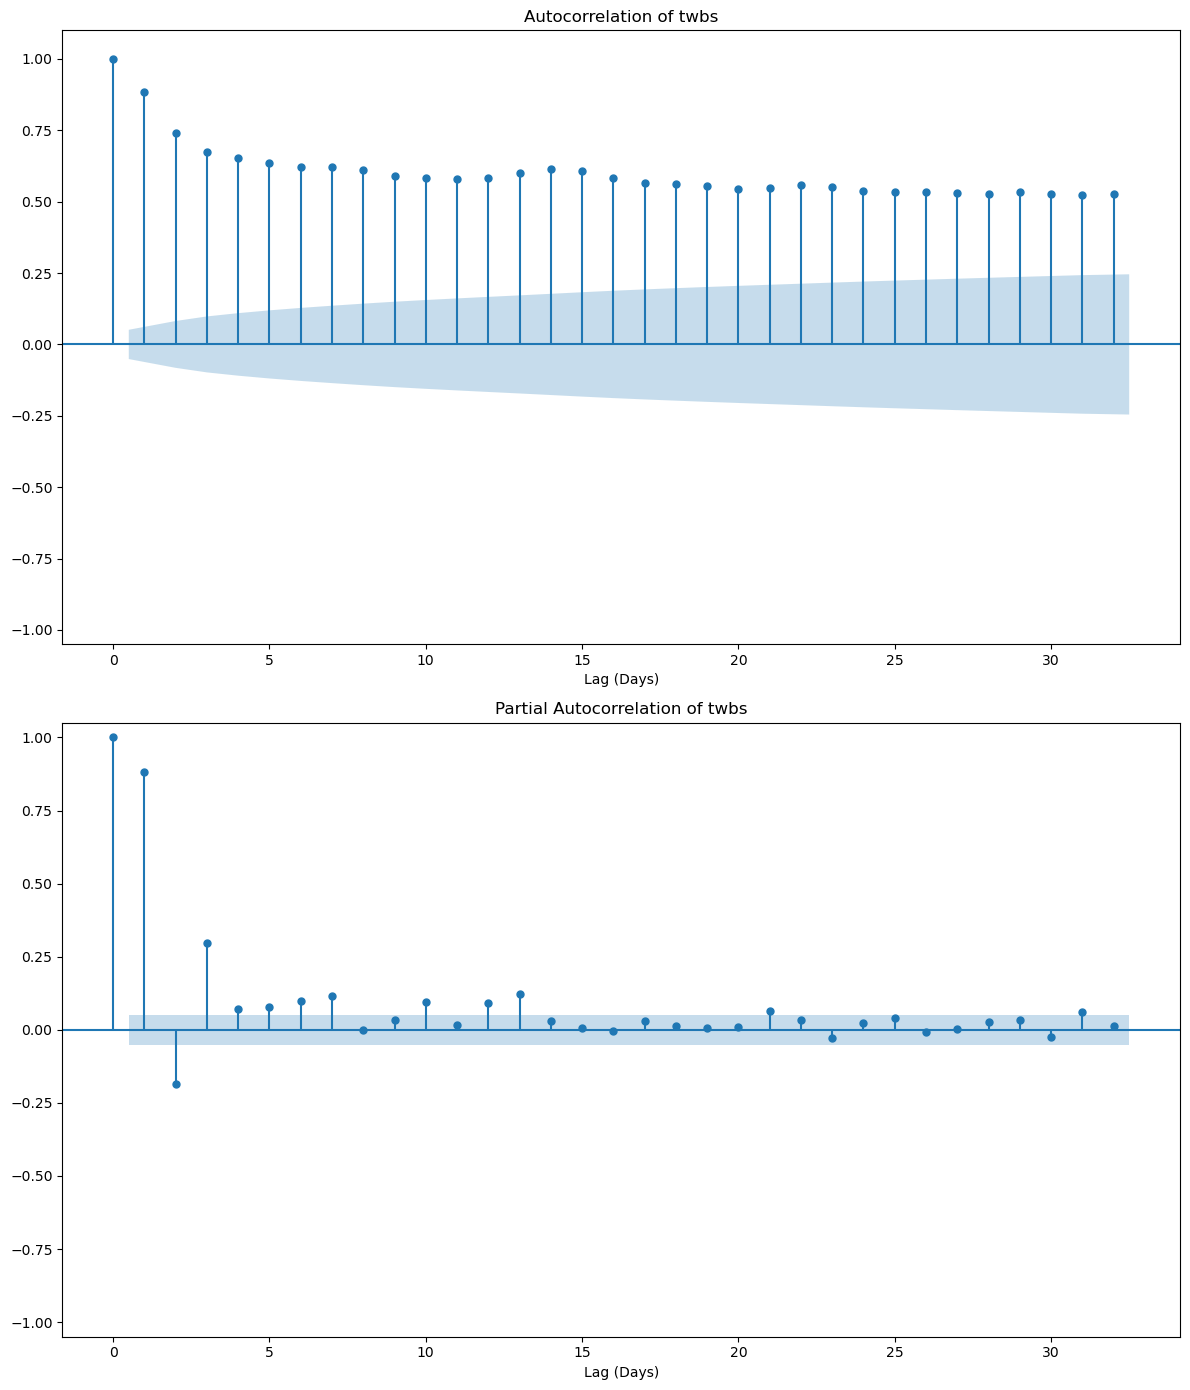

In [80]:
for var in variables: 
    file_path = os.path.join(home, var, 'netcdf' , f'Harris_County_PRISM_{var}_stable_4km{daily}_{years[0]}_{years[-1]}.nc') 
    ds = xr.open_dataset(file_path)

    da = ds[var]  
    ts = da.values

    plot_acf_pacf(ts, var)

## Detrend

In [66]:
import matplotlib.pyplot as plt
from scipy.signal import detrend 
import pandas as pd
from scipy import stats
variables = ['twbs', 'ppt']
years = ['2020', '2021', '2022']
daily = "D2"
# fig, ax = plt.subplots(1,1, figsize = (10,4))
home = '/home/sd96/rdf'


paths = {'ppt': os.path.join(home, 'ppt', 'netcdf', 'Harris_County_PRISM_ppt_stable_4kmD2_2020_2023.nc'), 
         'twbs': os.path.join(home, 'twbs', 'netcdf', 'Harris_County_PRISM_twbs_stable_4kmD2_2020_2023.nc')}

ppt = xr.open_dataset(paths['ppt'])
df_ppt = ppt.to_dataframe()

twbs = xr.open_dataset(paths['twbs'])

twbs_vector = twbs['twbs'].values

# Shape becomes (1461, 1)
twbs_vector = twbs_vector.reshape(1, -1) 
print("twbs_vector shape", twbs_vector.shape) 

print(twbs_vector)
twbs_cov = np.cov(twbs_vector)
print(twbs_cov)

twbs_vector_T = twbs_vector.T 
print(np.cov(twbs_vector_T))
print("twbs_vector_T shape", twbs_vector_T.shape) 

cov_array =  twbs_vector @ twbs_vector_T

print(cov_array.shape)
precision = np.linalg.inv(cov_array)

cov_obj = stats.Covariance.from_precision(precision) 

rng = np.random.default_rng()

print(cov_array.shape)
x = rng.multivariate_normal(np.zeros(1461), cov_array, size=(10000))
x = cov_object.whiten(x)

np.cov(x_, rowvar=False)

# twbs_whitened = cov_obj.whiten(twbs)

# print("Original covariance:", np.cov(twbs.T))
# print("Whitened covariance:", np.cov(twbs_whitened.T))

# # Plot autocorrelation before and after
# plot_acf(twbs.flatten(), lags=100)
# plt.title("ACF: Original twbs")
# plt.show()

# plot_acf(twbs_whitened.flatten(), lags=100)
# plt.title("ACF: Whitened twbs")
# plt.show()

twbs_vector shape (1, 1461)
[[ 4.90382522 11.23462391 14.96761915 ...  4.43831233  3.71914247
   6.19918077]]
49.64343484130804
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
twbs_vector_T shape (1461, 1)
(1, 1)
(1, 1)


/tmp/ipykernel_23571/2172676886.py:31: RuntimeWarning: Degrees of freedom <= 0 for slice
  print(np.cov(twbs_vector_T))
/home/sd96/miniforge3/envs/conda_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/sd96/miniforge3/envs/conda_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


ValueError: mean and cov must have same length